# Twitter Financial News Sentiment Dataset & Reddit Crypto Sentiment Dataset 

## Idea

Reference - https://huggingface.co/datasets/zeroshot/twitter-financial-news-sentiment

- Idea here is to leverage external dataset from similar domain to see if performance of a model improves.
- I used Twitter Financial News Sentiment Dataset from HuggingFace.
- Stats, 
    - The dataset holds 11,932 documents annotated with 3 labels:
    - Sentiments: Bearish, Bullish, Neutral
- I've hypothesize that Bearish correlates to Negative Sentiment & Bullish correlates to Positive Sentiment. 
- So after dropping documents with Neutral label from the dataset and mapping Bearish to Negative as well as Bullish to Positive class,
    - No. of Negative Samples - 1442
    - No. of Positive Samples - 1922
- Now, I combine twitter dataset to our existing dataset from reddit dataset & train modeld using previous configurations.

# Configuration

## Featurization of Text

Two approaches to featurize text:- 
    
    1. Count Vectorizer (Unigrams/Bigrams/Trigrams)
    2. Tfidf Vectorizer

## Modeling

Fit the following 5 models on the given text data and would choose the best one:-
    
    1. Naive Bayes
    2. Logistic Regression
    3. Linear SVM
    4. GBDT
    5. Random Forest

For each of the above models, we would do hyperparameter tuning.

# Observations from Results

- We tried two types of featuring techniques, _CountVectorizer_, _TFIDFVectorizer_ with __Unigram/Bigram/Trigram__ Model
- We applied both the above mentioned Featur Engineering techniques to 5 Classical ML Models, 
    - _Naive Bayes_
    - _Logistic Regression_
    - _Linear SVM_
    - _Gradient Boosted DT_
    - _Random Forest_
- Data Statistics
    - Twitter Financial News Sentiment (Samples) - __3364__
    - Reddit Crpto Sentiment (Samples) - __550__
    - Overall size (Samples) - __3914__
- I've divided the dataset into _train/test split_ of __75/25__ using __stratified sampling__ to maintain the distribution of __both the sources equally__ in training and testing sets. 
- Applied __5 fold__ _CrossValidation_ while doing Grid Search for Hyper Parameter tuning.
- Results shows __no imporovement__ rather get __worse__ when we look test results of dataset from Reddit comapred to previous approaches by almost all the models in binary classification task in terms of standard perfomance measures.
- One of the many reasons of performance getting worse could be,
    - Domains are not very similar
    - Transfer learning may not be working very well with Classical ML approaches.
    - Vocabulary of two dataset is very different and is not highly overlapping. 
- I've tried increasing the number of features to allow model to have wide range of features combing tokens from both the dataset but it didn't help.
- While testing the performance on Reddit Crypto Dataset, 
    - Average _F1 Score_ across all the model remian between __0.55 - 0.64__.
- Best Preformance:
    - GBDT with CountVectorizer(CBOW) with Trigram Vecotrs
    - _F1 Score (Reddit):_ __0.642__
    - _F1 Score:_ __0.777__

# PreProcessing (Preparation of training data)

In [1]:
# Importing the libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier as gbc
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import hstack

## Importing the PreProcessed Data

In [2]:
# Importing the preprocessed_data

preprocessed_data = pd.read_csv("../data/processed_combined_dataset.csv")

preprocessed_data

,class,sentiment,comment_text,processed_text,source
0,1,Positive,"I bought 2200 at the ico, at 0.50$ per coin. H...",bought 2200 ico 050 coin hold sold 3 months ag...,reddit
1,1,Positive,"Harmony one , algorand , Cardano, solana , vec...",harmony algorand cardano solana vechain gonna ...,reddit
2,0,Negative,"Honestly, after reading this post and many of ...",honestly reading post responses conclude crypt...,reddit
3,1,Positive,In bear market is where money is made. I Will ...,bear market money continue dca assets believe,reddit
4,0,Negative,Funny how people think Bitcoin's risk is compa...,funny people think bitcoins risk comparable st...,reddit
...,...,...,...,...,...
3909,1,Positive,Why Slack Stock Just Surged 17%,slack stock surged 17,twitter
3910,1,Positive,Why Tiffany Stock Just Popped 6%,tiffany stock popped 6,twitter
3911,1,Positive,WiLAN signs wireless license with LG; shares +...,wilan signs wireless license lg shares 7 pm,twitter
3912,1,Positive,"Yandex authorizes share repurchase program, sh...",yandex authorizes share repurchase program sha...,twitter


In [3]:
preprocessed_data.fillna('', inplace=True)

# Checking for no preprocessed text
def check_no_preprocessed_text(df):
    return [i for i in range(len(df)) if len(str(df.iloc[i,1]).split())==0]

# Calling the function check_no_preprocessed_text to check the index which has no text

list_of_indices = check_no_preprocessed_text(preprocessed_data)

list_of_indices

[]

In [4]:
# Dropping the rows which has no text

preprocessed_data = preprocessed_data.drop(labels = list_of_indices, axis = 0)

preprocessed_data.shape

(3914, 5)

In [5]:
# Checking whether there are two same texts in the data

duplicate_text = preprocessed_data[preprocessed_data.duplicated(subset = ['processed_text','sentiment'])]
duplicate_text

,class,sentiment,comment_text,processed_text,source


In [6]:
preprocessed_data = preprocessed_data.drop(labels=list(duplicate_text.index), axis=0)
preprocessed_data

,class,sentiment,comment_text,processed_text,source
0,1,Positive,"I bought 2200 at the ico, at 0.50$ per coin. H...",bought 2200 ico 050 coin hold sold 3 months ag...,reddit
1,1,Positive,"Harmony one , algorand , Cardano, solana , vec...",harmony algorand cardano solana vechain gonna ...,reddit
2,0,Negative,"Honestly, after reading this post and many of ...",honestly reading post responses conclude crypt...,reddit
3,1,Positive,In bear market is where money is made. I Will ...,bear market money continue dca assets believe,reddit
4,0,Negative,Funny how people think Bitcoin's risk is compa...,funny people think bitcoins risk comparable st...,reddit
...,...,...,...,...,...
3909,1,Positive,Why Slack Stock Just Surged 17%,slack stock surged 17,twitter
3910,1,Positive,Why Tiffany Stock Just Popped 6%,tiffany stock popped 6,twitter
3911,1,Positive,WiLAN signs wireless license with LG; shares +...,wilan signs wireless license lg shares 7 pm,twitter
3912,1,Positive,"Yandex authorizes share repurchase program, sh...",yandex authorizes share repurchase program sha...,twitter


In [7]:
preprocessed_data["processed_text_len"] = preprocessed_data["processed_text"].apply(lambda x: len(x))
preprocessed_data

,class,sentiment,comment_text,processed_text,source,processed_text_len
0,1,Positive,"I bought 2200 at the ico, at 0.50$ per coin. H...",bought 2200 ico 050 coin hold sold 3 months ag...,reddit,71
1,1,Positive,"Harmony one , algorand , Cardano, solana , vec...",harmony algorand cardano solana vechain gonna ...,reddit,80
2,0,Negative,"Honestly, after reading this post and many of ...",honestly reading post responses conclude crypt...,reddit,171
3,1,Positive,In bear market is where money is made. I Will ...,bear market money continue dca assets believe,reddit,45
4,0,Negative,Funny how people think Bitcoin's risk is compa...,funny people think bitcoins risk comparable st...,reddit,105
...,...,...,...,...,...,...
3909,1,Positive,Why Slack Stock Just Surged 17%,slack stock surged 17,twitter,21
3910,1,Positive,Why Tiffany Stock Just Popped 6%,tiffany stock popped 6,twitter,22
3911,1,Positive,WiLAN signs wireless license with LG; shares +...,wilan signs wireless license lg shares 7 pm,twitter,43
3912,1,Positive,"Yandex authorizes share repurchase program, sh...",yandex authorizes share repurchase program sha...,twitter,61


## Splitting Data into Training and Cross Validation sets

In [8]:
X = preprocessed_data[['processed_text', 'processed_text_len']]
Y = preprocessed_data[['class', 'source']]

In [9]:
# Importing the library
X_train, X_test, Y_train_with_src, Y_test_with_src = train_test_split(X,Y,test_size = 0.25, stratify = Y, random_state = 42)

In [10]:
X_train.shape, X_test.shape

((2935, 2), (979, 2))

In [11]:
Y_train_with_src.shape, Y_test_with_src.shape

((2935, 2), (979, 2))

In [12]:
Y_train_with_src.value_counts()

class  source 
1      twitter    1441
0      twitter    1081
1      reddit      221
0      reddit      192
dtype: int64

In [13]:
Y_test_with_src.value_counts()

class  source 
1      twitter    481
0      twitter    361
1      reddit      73
0      reddit      64
dtype: int64

In [14]:
Y_train, Y_test = Y_train_with_src['class'], Y_test_with_src['class'] 
Y_train.shape, Y_test.shape

((2935,), (979,))

In [15]:
Y_train.value_counts()

1    1662
0    1273
Name: class, dtype: int64

In [16]:
Y_test.value_counts()

1    554
0    425
Name: class, dtype: int64

## Text Featurization

### CountVectorizer/BOW(Bag of Words)

In [17]:
# Countvectorizer or Bag of Words on unigrams

countvec = CountVectorizer(min_df=5, ngram_range = (1,3), max_features=1000)
preprocessed_train_bow = countvec.fit_transform(X_train.processed_text.values)
print("Shape of the training data after fitting Countvectorizer ", preprocessed_train_bow.shape)

Shape of the training data after fitting Countvectorizer  (2935, 1000)


In [18]:
# Transforming the test data also

preprocessed_test_bow = countvec.transform(X_test.processed_text.values)
print("Shape of the test data after fitting Countvectorizer ", preprocessed_test_bow.shape)

Shape of the test data after fitting Countvectorizer  (979, 1000)


### TFIDF Vectorizer

In [19]:
# Countvectorizer or Bag of Words on unigrams

tfidfvec = TfidfVectorizer(min_df=5, ngram_range = (1,3), max_features=1000)
preprocessed_train_tfidf = tfidfvec.fit_transform(X_train.processed_text.values)
print("Shape of the training data after fitting Tfidfvectorizer ", preprocessed_train_tfidf.shape)

Shape of the training data after fitting Tfidfvectorizer  (2935, 1000)


In [20]:
# Transforming the test data also

#preprocessed_cv_tfidf = tfidfvec.transform(X_CV)
preprocessed_test_tfidf = tfidfvec.transform(X_test.processed_text.values)
print("Shape of the test data after fitting Tfidfvectorizer ",preprocessed_test_tfidf.shape)

Shape of the test data after fitting Tfidfvectorizer  (979, 1000)


## Scaling of Numerical Features

In [21]:
minmax = MinMaxScaler()

prep_length_train = minmax.fit_transform(X_train.processed_text_len.values.reshape(-1,1))
prep_length_test  = minmax.transform(X_test.processed_text_len.values.reshape(-1,1))

## Final Feature Matrix

In [22]:
preprocessed_train_bow = hstack((preprocessed_train_bow,prep_length_train))
preprocessed_test_bow = hstack((preprocessed_test_bow,prep_length_test))
preprocessed_train_tfidf = hstack((preprocessed_train_tfidf,prep_length_train))
preprocessed_test_tfidf = hstack((preprocessed_test_tfidf,prep_length_test))

## Utility Functions

### Function to plot CONFUSION MATRIX along with PRECISION & RECALL Matrix

In [23]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 2,2 matrix, each cell (i,j) represents number of points of class i are predicted class j
    # The predictions are along the columns of the confusion matrix whereas the actual values are along the rows of confusion matrix.
    
    A =(((C.T)/(C.sum(axis=1))).T)
        
    B =(C/C.sum(axis=0))
        
    labels = [0,1]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    #print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(20,4))
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    #plt.show()

    #print("-"*50, "Precision matrix", "-"*50)
    #plt.figure(figsize=(10,5))
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    #plt.show()
    #print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    #print("-"*50, "Recall matrix"    , "-"*50)
    #plt.figure(figsize=(10,5))
    plt.subplot(1, 3, 3)
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    #plt.show()
    #print("Sum of rows in Recall matrix",A.sum(axis=1))

### Function to Calculate Best Threshold & Predict with the Same

In [24]:
def find_best_threshold(threshould, fpr, tpr):
    # t = threshould[np.argmax(tpr*(1-fpr))]
    t = 0.5
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

# Training -> Grid Search ->  Testing

## NAIVE BAYES
### Hyperparameter Tuning

    1. Hyperparameter tuning would be based on the parameter alpha which is additive or Laplace Smoothing parameter that prevents posteriors for unseen data points to become zero.
    2. The best hyperparameter would be choosen for the highest Recall.



### CountVectorizer/BOW(Bag of Words)

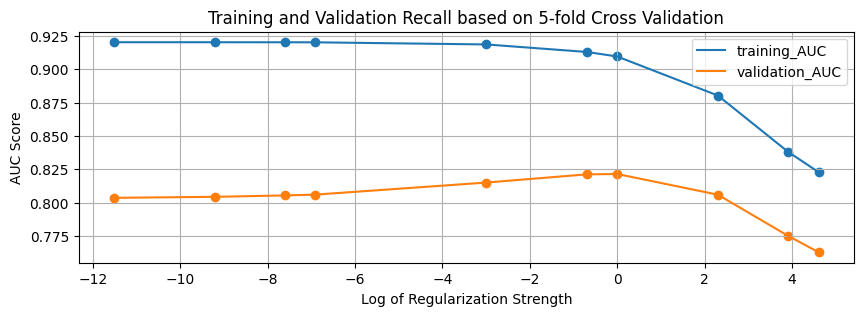

The best regularization strength parameter alpha on the random search over the given hyperparameter space for CountVectorizer is :  {'alpha': 1}


In [25]:
NB = MultinomialNB()
params = {'alpha': [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}

clf = RandomizedSearchCV(NB, param_distributions = params, scoring = 'roc_auc', cv=5, return_train_score = True, random_state = 42)
clf.fit(preprocessed_train_bow, Y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results.sort_values(by = "param_alpha", inplace=True)


train_recall = results["mean_train_score"]
train_std = results["std_train_score"]
cv_recall = results["mean_test_score"]
cv_std = results["std_test_score"]
hparam = pd.Series([np.log(x) for x in results.param_alpha.values])

plt.figure(figsize = (10,3))
plt.plot(hparam, train_recall, label = "training_AUC")
plt.plot(hparam, cv_recall, label = "validation_AUC")
plt.scatter(hparam, train_recall)
plt.scatter(hparam, cv_recall)
plt.xlabel("Log of Regularization Strength")
plt.ylabel("AUC Score")
plt.title("Training and Validation Recall based on 5-fold Cross Validation")
plt.legend()
plt.grid()
plt.show()

print("The best regularization strength parameter alpha on the random search " + 
      "over the given hyperparameter space for CountVectorizer is : ", clf.best_params_)
clf_nb_cbow_params = clf.best_params_

### TFIDF Vectorizer

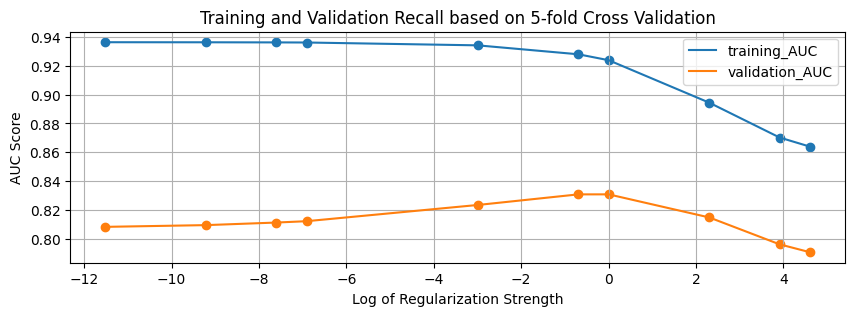

The best regularization strength parameter alpha on the random search over the given hyperparameter space for TFIDF Vectorizer is :  {'alpha': 1}


In [26]:
NB = MultinomialNB()
params = {'alpha': [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}

clf = RandomizedSearchCV(NB, param_distributions = params, scoring = 'roc_auc', cv=5, return_train_score = True, random_state = 42)
clf.fit(preprocessed_train_tfidf, Y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results.sort_values(by = "param_alpha", inplace=True)

train_recall = results["mean_train_score"]
train_std = results["std_train_score"]
cv_recall = results["mean_test_score"]
cv_std = results["std_test_score"]
hparam = pd.Series([np.log(x) for x in results.param_alpha.values])

plt.figure(figsize = (10,3))
plt.plot(hparam, train_recall, label = "training_AUC")
plt.plot(hparam, cv_recall, label = "validation_AUC")
plt.scatter(hparam, train_recall)
plt.scatter(hparam, cv_recall)
plt.xlabel("Log of Regularization Strength")
plt.ylabel("AUC Score")
plt.title("Training and Validation Recall based on 5-fold Cross Validation")
plt.legend()
plt.grid()
plt.show()

print("The best regularization strength parameter alpha on the random search " + 
      "over the given hyperparameter space for TFIDF Vectorizer is : ", clf.best_params_)
clf_nb_tfidf_params = clf.best_params_

### Best Model Fitting

#### CountVectorizer/BOW(Bag of Words)

Params of a Best model - {'alpha': 1, 'class_prior': None, 'fit_prior': True, 'force_alpha': 'warn'}


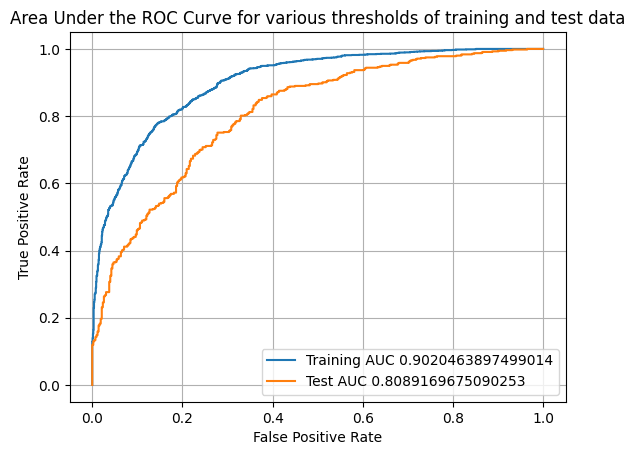

In [27]:
# Fitting the multinomial naive bayes algorithm
best_mod = MultinomialNB()
best_mod.set_params(**clf_nb_cbow_params)
print("Params of a Best model - {}".format(best_mod.get_params()))

best_mod.fit(preprocessed_train_bow, Y_train)

y_train_pred = best_mod.predict_proba(preprocessed_train_bow)[:,1]
y_test_pred = best_mod.predict_proba(preprocessed_test_bow)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

#plt.figure(figsize = (10,5))
plt.plot(train_fpr, train_tpr, label = "Training AUC " + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "Test AUC " + str(auc(test_fpr, test_tpr)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area Under the ROC Curve for various thresholds of training and test data")
plt.legend()
plt.grid()
plt.show()

##### OVERALL - Test Data Prediction & Conf Matrix

the maximum value of tpr*(1-fpr) 0.6662620774145612 for threshold 0.5
Number of misclassified points  26.251276813074565


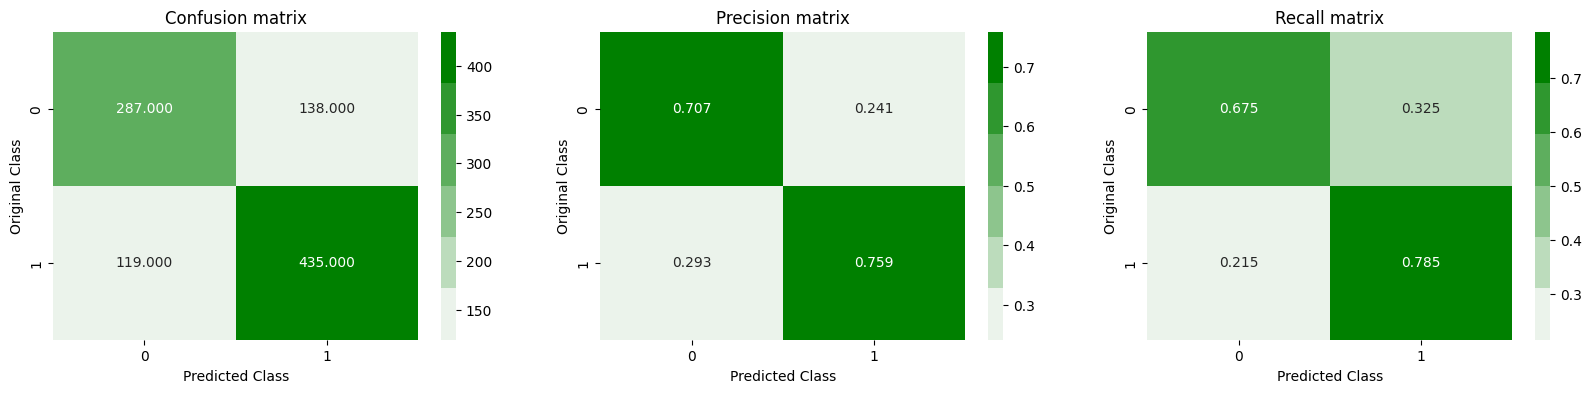

In [28]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
y_pred = predict_with_best_t(y_test_pred, best_t)
plot_confusion_matrix(Y_test, y_pred)

best_threshold_NB_bow = best_t

In [29]:
accuracy_a1 = accuracy_score(Y_test, y_pred)
precision_a1 = precision_score(Y_test, y_pred)
recall_a1 = recall_score(Y_test, y_pred)
f1_a1 = f1_score(Y_test, y_pred)
print('Accuracy: %.3f' % accuracy_a1, 'Precision: %.3f' % precision_a1, 'Recall: %.3f' % recall_a1, 'F1: %.3f' % f1_a1)

Accuracy: 0.737 Precision: 0.759 Recall: 0.785 F1: 0.772


##### REDDIT - Test Data Prediction & Conf Matrix

the maximum value of tpr*(1-fpr) 0.6662620774145612 for threshold 0.5
Number of misclassified points  48.9051094890511


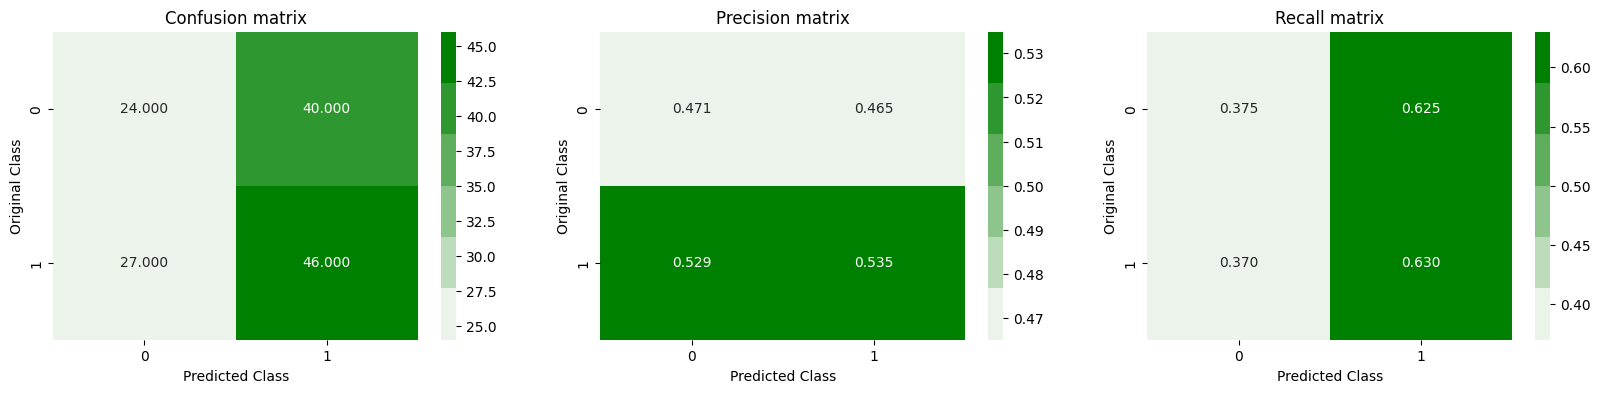

In [30]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
y_pred_reddit = predict_with_best_t(y_test_pred[Y_test_with_src[Y_test_with_src["source"].isin(["reddit"])].index], best_t)
Y_test_reddit = Y_test_with_src[Y_test_with_src["source"].isin(["reddit"])]["class"]
plot_confusion_matrix(Y_test_reddit, y_pred_reddit)

In [31]:
accuracy_reddit_a1 = accuracy_score(Y_test_reddit, y_pred_reddit)
precision_reddit_a1 = precision_score(Y_test_reddit, y_pred_reddit)
recall_reddit_a1 = recall_score(Y_test_reddit, y_pred_reddit)
f1_reddit_a1 = f1_score(Y_test_reddit, y_pred_reddit)
print('Accuracy: %.3f' % accuracy_reddit_a1, 'Precision: %.3f' % precision_reddit_a1, 'Recall: %.3f' % recall_reddit_a1, 'F1: %.3f' % f1_reddit_a1)

Accuracy: 0.511 Precision: 0.535 Recall: 0.630 F1: 0.579


#### TFIDF Vectorizer

Params of a Best model - {'alpha': 1, 'class_prior': None, 'fit_prior': True, 'force_alpha': 'warn'}


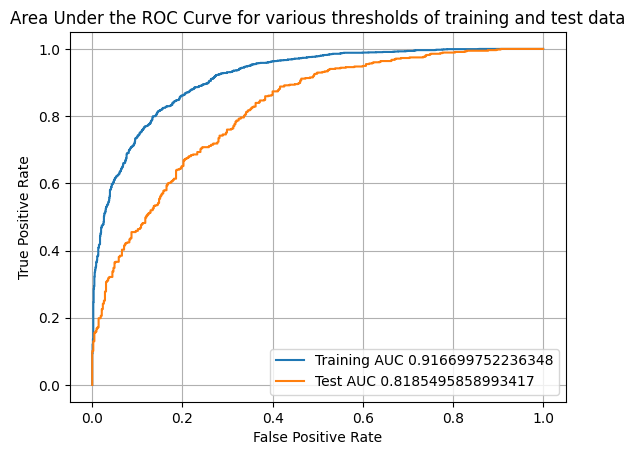

In [32]:
# Fitting the multinomial naive bayes algorithm
best_mod = MultinomialNB()
best_mod.set_params(**clf_nb_tfidf_params)
print("Params of a Best model - {}".format(best_mod.get_params()))

best_mod.fit(preprocessed_train_tfidf, Y_train)

y_train_pred = best_mod.predict_proba(preprocessed_train_tfidf)[:,1]
y_test_pred = best_mod.predict_proba(preprocessed_test_tfidf)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

#plt.figure(figsize = (10,5))
plt.plot(train_fpr, train_tpr, label = "Training AUC " + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "Test AUC " + str(auc(test_fpr, test_tpr)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area Under the ROC Curve for various thresholds of training and test data")
plt.legend()
plt.grid()
plt.show()

##### OVERALL - Test Data Prediction & Conf Matrix

the maximum value of tpr*(1-fpr) 0.6955201193349233 for threshold 0.5
Number of misclassified points  24.616956077630235


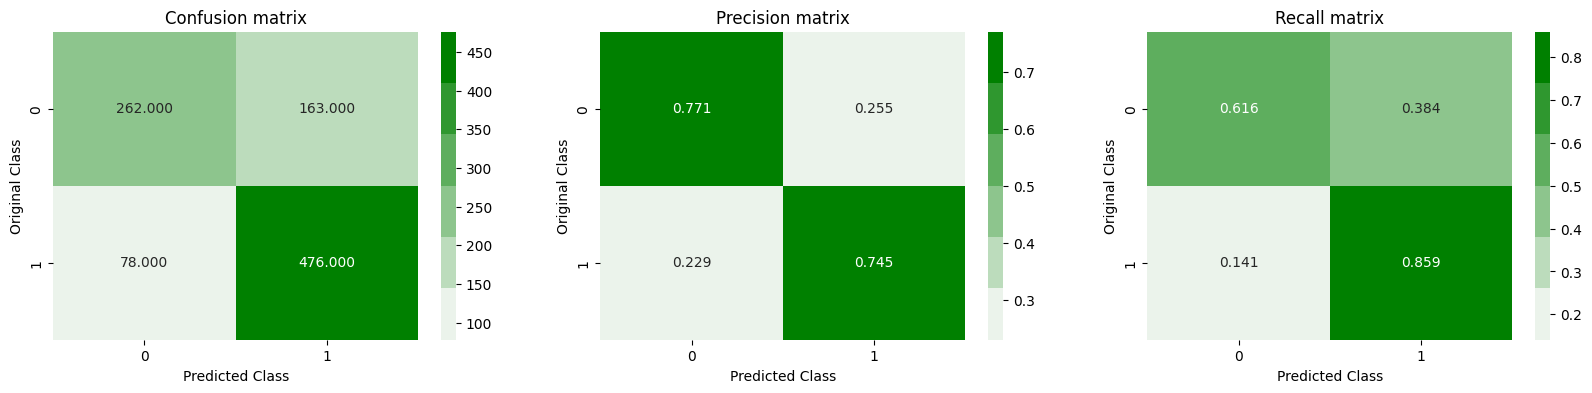

In [33]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
y_pred = predict_with_best_t(y_test_pred, best_t)
plot_confusion_matrix(Y_test, y_pred)

best_threshold_NB_tfidf = best_t

In [34]:
accuracy_b1 = accuracy_score(Y_test, y_pred)
precision_b1 = precision_score(Y_test, y_pred)
recall_b1 = recall_score(Y_test, y_pred)
f1_b1 = f1_score(Y_test, y_pred)
print('Accuracy: %.3f' % accuracy_b1, 'Precision: %.3f' % precision_b1, 'Recall: %.3f' % recall_b1, 'F1: %.3f' % f1_b1)

Accuracy: 0.754 Precision: 0.745 Recall: 0.859 F1: 0.798


##### REDDIT - Test Data Prediction & Conf Matrix

the maximum value of tpr*(1-fpr) 0.6955201193349233 for threshold 0.5
Number of misclassified points  52.55474452554745


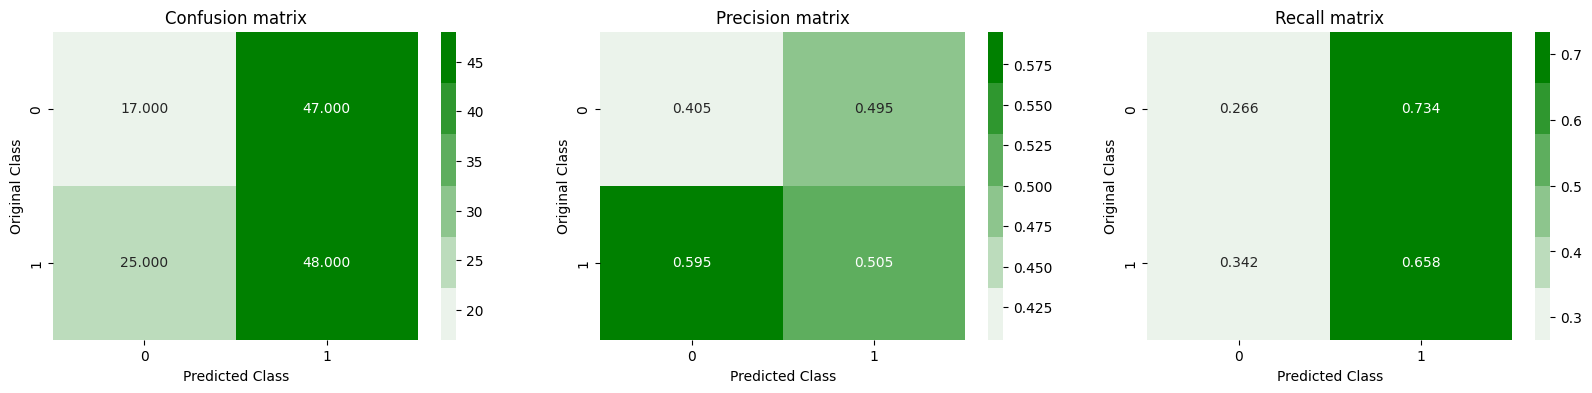

In [35]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
y_pred_reddit = predict_with_best_t(y_test_pred[Y_test_with_src[Y_test_with_src["source"].isin(["reddit"])].index], best_t)
Y_test_reddit = Y_test_with_src[Y_test_with_src["source"].isin(["reddit"])]["class"]
plot_confusion_matrix(Y_test_reddit, y_pred_reddit)

In [36]:
accuracy_reddit_b1 = accuracy_score(Y_test_reddit, y_pred_reddit)
precision_reddit_b1 = precision_score(Y_test_reddit, y_pred_reddit)
recall_reddit_b1 = recall_score(Y_test_reddit, y_pred_reddit)
f1_reddit_b1 = f1_score(Y_test_reddit, y_pred_reddit)
print('Accuracy: %.3f' % accuracy_reddit_b1, 'Precision: %.3f' % precision_reddit_b1, 'Recall: %.3f' % recall_reddit_b1, 'F1: %.3f' % f1_reddit_b1)

Accuracy: 0.474 Precision: 0.505 Recall: 0.658 F1: 0.571


## LOGISTIC REGRESSION
### Hyperparameter Tuning
    1. Alpha which is directly proportional to regularization.
    2. Penalty which could L1, L2 or Elastic Net

### CountVectorizer/BOW(Bag of Words)

The best set of parameters for the LR Classifier on the BOW featurized data are : {'penalty': 'l2', 'alpha': 0.001}


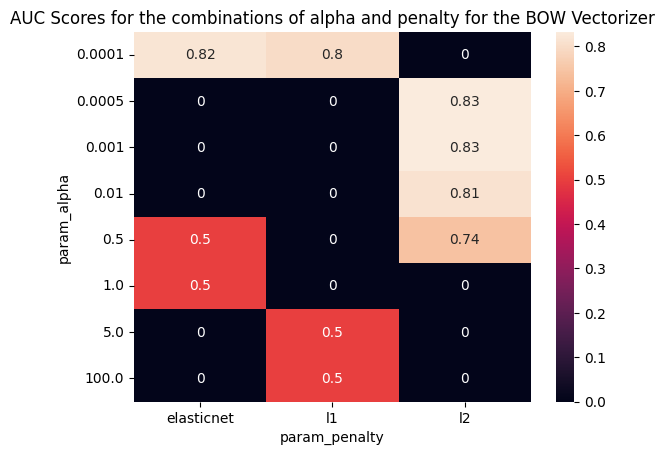

In [37]:
LR = SGDClassifier(loss = 'log_loss')

params = {'alpha': [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100], 'penalty':['l1','l2','elasticnet']}

clf = RandomizedSearchCV(LR, param_distributions = params, scoring = 'roc_auc', cv=5, return_train_score = True, random_state = 42)
clf.fit(preprocessed_train_bow, Y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results.sort_values(by = ["param_alpha","param_penalty"], inplace=True)


train_auc = results["mean_train_score"]
train_std = results["std_train_score"]
cv_auc = results["mean_test_score"]
cv_std = results["std_test_score"]
#hparam_alpha = pd.Series([np.log(x) for x in results.param_alpha.values])
#hparam_penalty = results.param_penalty.values

score_df = pd.pivot_table(data = results, index = "param_alpha", columns = "param_penalty", values = "mean_test_score")

# Removing the nan values from the dataset to avoid any errors during plotting of the auc scores for various combinations
score_df.fillna(0, inplace=True)

sns.heatmap(score_df, annot = True)
plt.title("AUC Scores for the combinations of alpha and penalty for the BOW Vectorizer")

print("The best set of parameters for the LR Classifier on the BOW featurized data are : {}".format(clf.best_params_))
clf_lr_cbow_params = clf.best_params_

### TFIDF Vectorizer

The best set of parameters for the LR Classifier on the TFIDF featurized data are : {'penalty': 'l2', 'alpha': 0.0005}


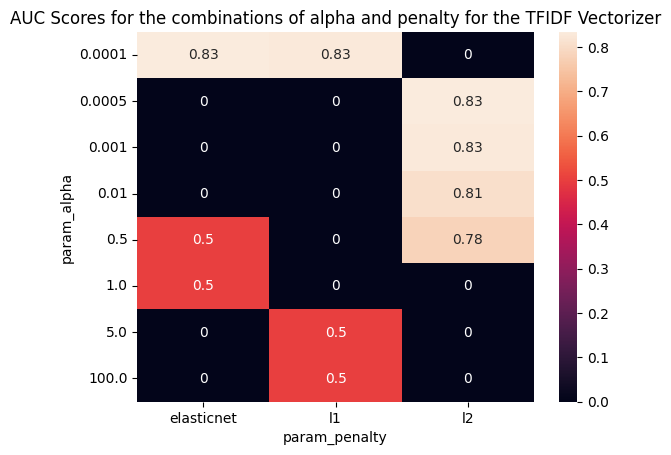

In [38]:
LR = SGDClassifier(loss = 'log_loss')

params = {'alpha': [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100], 'penalty':['l1','l2','elasticnet']}

clf = RandomizedSearchCV(LR, param_distributions = params, scoring = 'roc_auc', cv=5, return_train_score = True, random_state = 42)
clf.fit(preprocessed_train_tfidf, Y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results.sort_values(by = ["param_alpha","param_penalty"], inplace=True)


train_auc = results["mean_train_score"]
train_std = results["std_train_score"]
cv_auc = results["mean_test_score"]
cv_std = results["std_test_score"]
#hparam_alpha = pd.Series([np.log(x) for x in results.param_alpha.values])
#hparam_penalty = results.param_penalty.values

score_df = pd.pivot_table(data = results, index = "param_alpha", columns = "param_penalty", values = "mean_test_score")

# Removing the nan values from the dataset to avoid any errors during plotting of the auc scores for various combinations
score_df.fillna(0, inplace=True)

sns.heatmap(score_df, annot = True)
plt.title("AUC Scores for the combinations of alpha and penalty for the TFIDF Vectorizer")

print("The best set of parameters for the LR Classifier on the TFIDF featurized data are : {}".format(clf.best_params_))
clf_lr_tfidf_params = clf.best_params_

### Best Model Fitting

#### CountVectorizer/BOW(Bag of Words)

Params of a Best model - {'alpha': 0.001, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'log_loss', 'max_iter': 1000, 'n_iter_no_change': 5, 'n_jobs': None, 'penalty': 'l2', 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


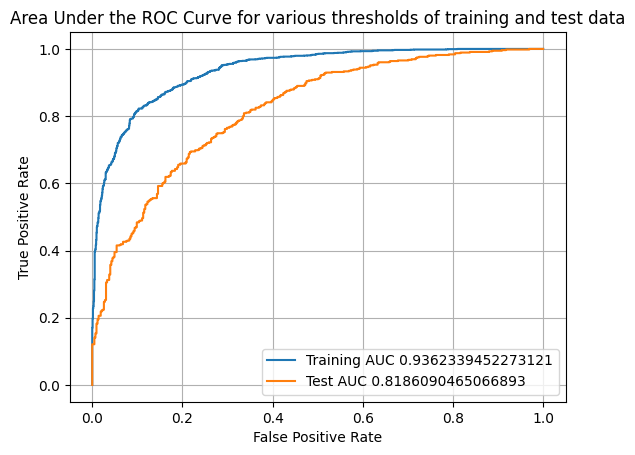

In [39]:
# Fitting the multinomial naive bayes algorithm
best_mod = SGDClassifier(loss = 'log_loss')
best_mod.set_params(**clf_lr_cbow_params)
print("Params of a Best model - {}".format(best_mod.get_params()))

best_mod.fit(preprocessed_train_bow, Y_train)

y_train_pred = best_mod.predict_proba(preprocessed_train_bow)[:,1]
y_test_pred = best_mod.predict_proba(preprocessed_test_bow)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

#plt.figure(figsize = (10,5))
plt.plot(train_fpr, train_tpr, label = "Training AUC " + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "Test AUC " + str(auc(test_fpr, test_tpr)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area Under the ROC Curve for various thresholds of training and test data")
plt.legend()
plt.grid()
plt.show()

##### OVERALL - Test Data Prediction & Conf Matrix

the maximum value of tpr*(1-fpr) 0.7373223186745352 for threshold 0.5
Number of misclassified points  25.842696629213485


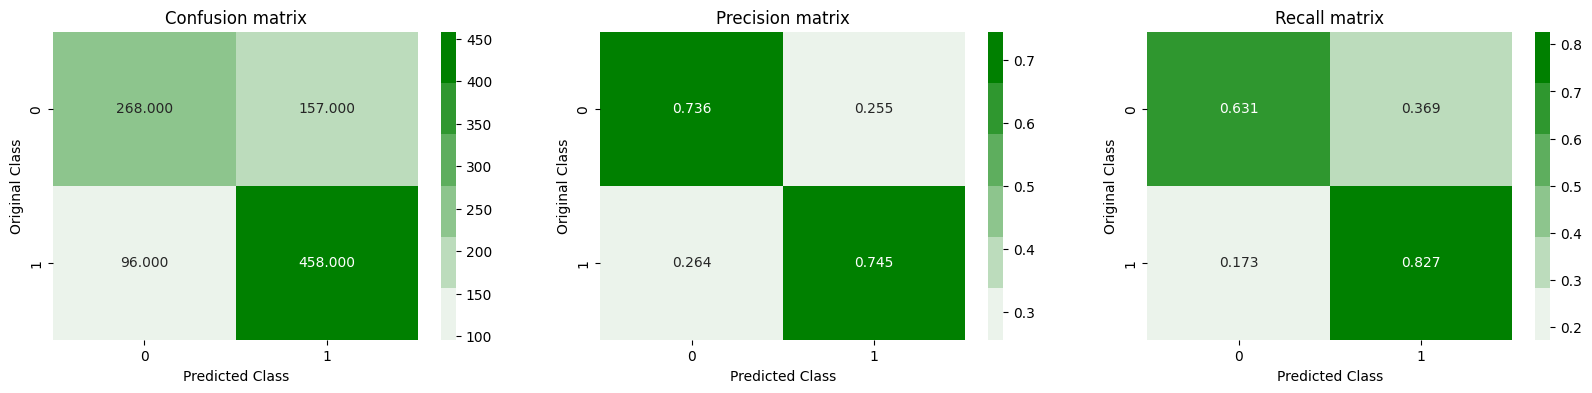

In [40]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
y_pred = predict_with_best_t(y_test_pred, best_t)
plot_confusion_matrix(Y_test, y_pred)

best_threshold_LR_bow = best_t

In [41]:
accuracy_a2 = accuracy_score(Y_test, y_pred)
precision_a2 = precision_score(Y_test, y_pred)
recall_a2 = recall_score(Y_test, y_pred)
f1_a2 = f1_score(Y_test, y_pred)
print('Accuracy: %.3f' % accuracy_a2, 'Precision: %.3f' % precision_a2, 'Recall: %.3f' % recall_a2, 'F1: %.3f' % f1_a2)

Accuracy: 0.742 Precision: 0.745 Recall: 0.827 F1: 0.784


##### REDDIT - Test Data Prediction & Conf Matrix

the maximum value of tpr*(1-fpr) 0.7373223186745352 for threshold 0.5
Number of misclassified points  51.82481751824818


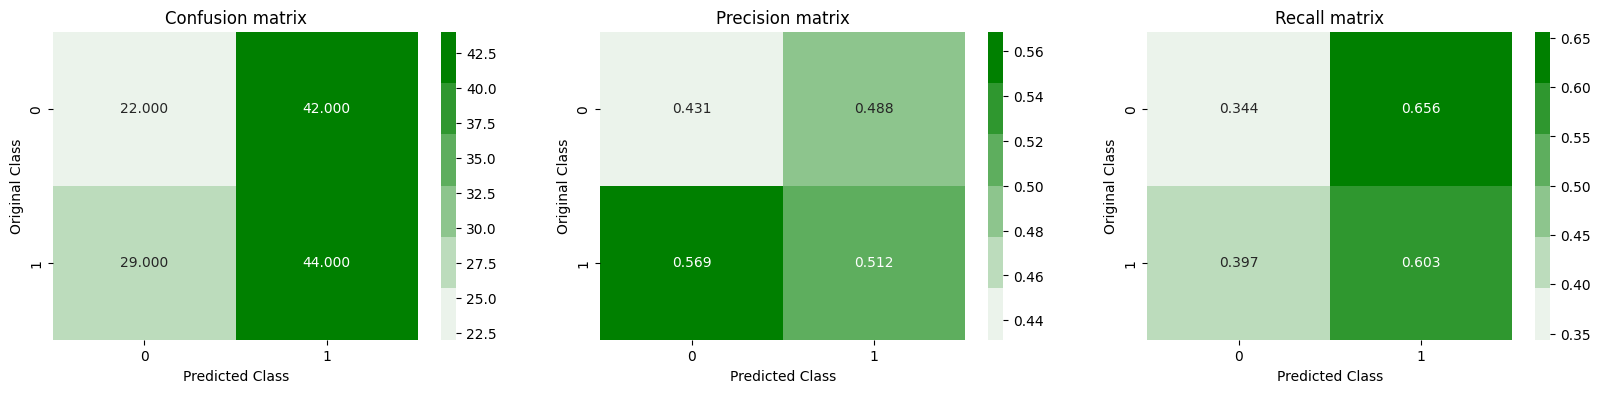

In [42]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
y_pred_reddit = predict_with_best_t(y_test_pred[Y_test_with_src[Y_test_with_src["source"].isin(["reddit"])].index], best_t)
Y_test_reddit = Y_test_with_src[Y_test_with_src["source"].isin(["reddit"])]["class"]
plot_confusion_matrix(Y_test_reddit, y_pred_reddit)

In [43]:
accuracy_reddit_a2 = accuracy_score(Y_test_reddit, y_pred_reddit)
precision_reddit_a2 = precision_score(Y_test_reddit, y_pred_reddit)
recall_reddit_a2 = recall_score(Y_test_reddit, y_pred_reddit)
f1_reddit_a2 = f1_score(Y_test_reddit, y_pred_reddit)
print('Accuracy: %.3f' % accuracy_reddit_a1, 'Precision: %.3f' % precision_reddit_a1, 'Recall: %.3f' % recall_reddit_a1, 'F1: %.3f' % f1_reddit_a1)

Accuracy: 0.511 Precision: 0.535 Recall: 0.630 F1: 0.579


#### TFIDF Vectorizer

Params of a Best model - {'alpha': 0.0005, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'log_loss', 'max_iter': 1000, 'n_iter_no_change': 5, 'n_jobs': None, 'penalty': 'l2', 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


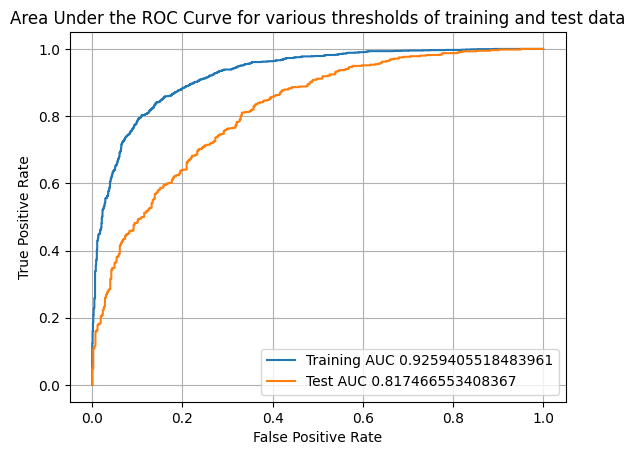

In [44]:
# Fitting the multinomial naive bayes algorithm
best_mod = SGDClassifier(loss = 'log_loss')
best_mod.set_params(**clf_lr_tfidf_params)
print("Params of a Best model - {}".format(best_mod.get_params()))

best_mod.fit(preprocessed_train_tfidf, Y_train)

y_train_pred = best_mod.predict_proba(preprocessed_train_tfidf)[:,1]
y_test_pred = best_mod.predict_proba(preprocessed_test_tfidf)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

#plt.figure(figsize = (10,5))
plt.plot(train_fpr, train_tpr, label = "Training AUC " + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "Test AUC " + str(auc(test_fpr, test_tpr)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area Under the ROC Curve for various thresholds of training and test data")
plt.legend()
plt.grid()
plt.show()

##### OVERALL - Test Data Prediction & Conf Matrix

the maximum value of tpr*(1-fpr) 0.7213268636865077 for threshold 0.5
Number of misclassified points  25.536261491317667


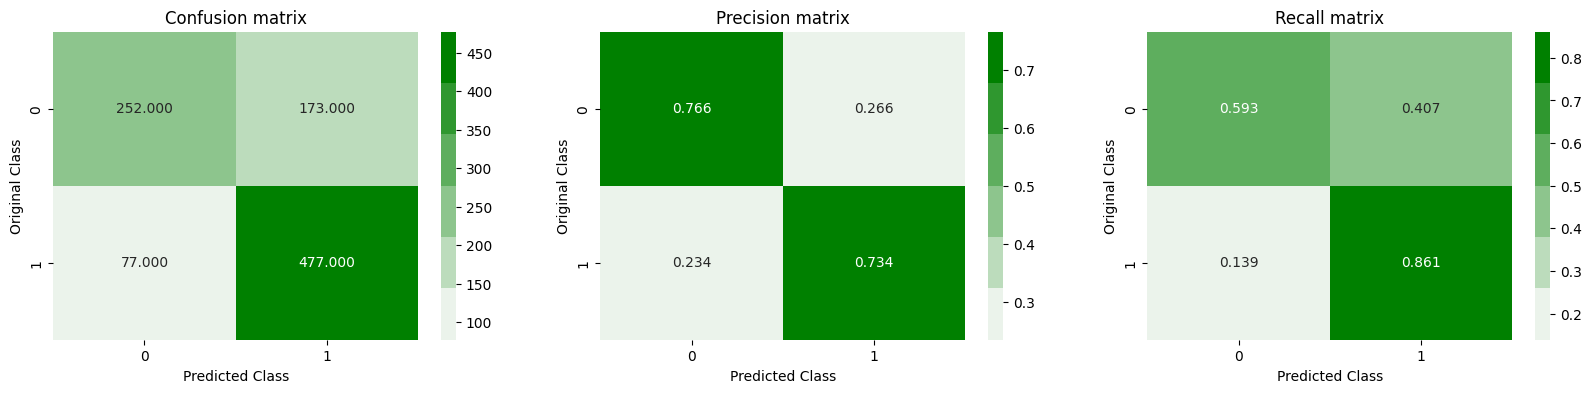

In [45]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
y_pred = predict_with_best_t(y_test_pred, best_t)
plot_confusion_matrix(Y_test, y_pred)

best_threshold_LR_tfidf = best_t

In [46]:
accuracy_b2 = accuracy_score(Y_test, y_pred)
precision_b2 = precision_score(Y_test, y_pred)
recall_b2 = recall_score(Y_test, y_pred)
f1_b2 = f1_score(Y_test, y_pred)
print('Accuracy: %.3f' % accuracy_b2, 'Precision: %.3f' % precision_b2, 'Recall: %.3f' % recall_b2, 'F1: %.3f' % f1_b2)

Accuracy: 0.745 Precision: 0.734 Recall: 0.861 F1: 0.792


##### REDDIT - Test Data Prediction & Conf Matrix

the maximum value of tpr*(1-fpr) 0.7213268636865077 for threshold 0.5
Number of misclassified points  51.09489051094891


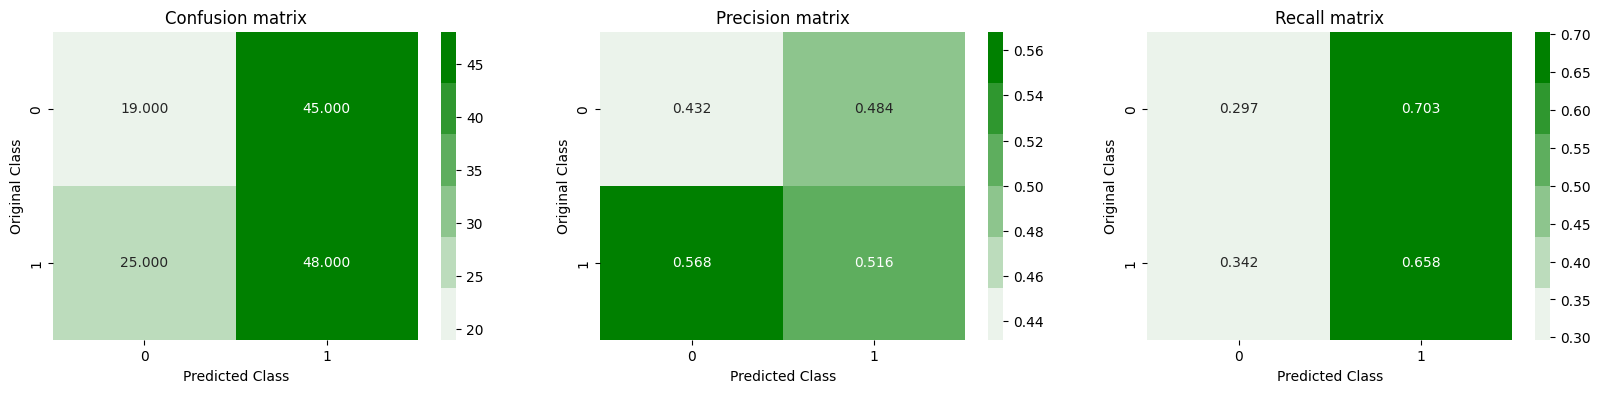

In [47]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
y_pred_reddit = predict_with_best_t(y_test_pred[Y_test_with_src[Y_test_with_src["source"].isin(["reddit"])].index], best_t)
Y_test_reddit = Y_test_with_src[Y_test_with_src["source"].isin(["reddit"])]["class"]
plot_confusion_matrix(Y_test_reddit, y_pred_reddit)

In [48]:
accuracy_reddit_b2 = accuracy_score(Y_test_reddit, y_pred_reddit)
precision_reddit_b2 = precision_score(Y_test_reddit, y_pred_reddit)
recall_reddit_b2 = recall_score(Y_test_reddit, y_pred_reddit)
f1_reddit_b2 = f1_score(Y_test_reddit, y_pred_reddit)
print('Accuracy: %.3f' % accuracy_reddit_b1, 'Precision: %.3f' % precision_reddit_b1, 'Recall: %.3f' % recall_reddit_b1, 'F1: %.3f' % f1_reddit_b1)

Accuracy: 0.474 Precision: 0.505 Recall: 0.658 F1: 0.571


## LINEAR SVM
### Hyperparameter Tuning
    1. C which is the inverse of the regularization strength and it penalizes the outliers.

### CountVectorizer/BOW(Bag of Words)

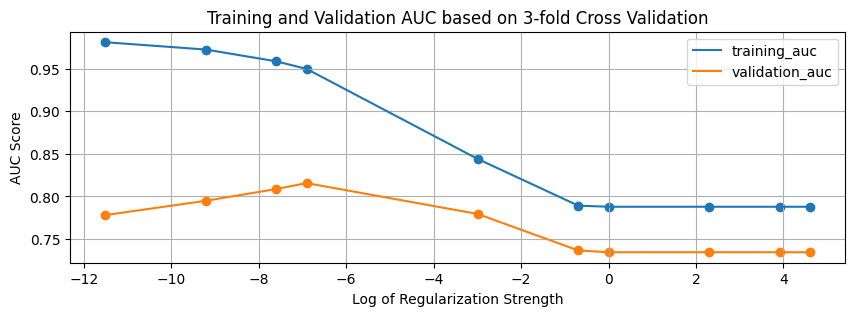

The best regularization strength parameter alpha on the random search over the given hyperparameter space for CountVectorizer using Linear SVM is :  {'alpha': 0.001}


In [49]:
SV = SGDClassifier(loss = 'hinge')

params = {'alpha': [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}

clf = RandomizedSearchCV(SV, param_distributions = params, scoring = 'roc_auc', cv=5, return_train_score = True, random_state = 42)
clf.fit(preprocessed_train_bow, Y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results.sort_values(by = "param_alpha", inplace=True)

train_auc = results["mean_train_score"]
train_std = results["std_train_score"]
cv_auc = results["mean_test_score"]
cv_std = results["std_test_score"]
hparam = pd.Series([np.log(x) for x in results.param_alpha.values])

plt.figure(figsize = (10,3))
plt.plot(hparam, train_auc, label = "training_auc")
plt.plot(hparam, cv_auc, label = "validation_auc")
plt.scatter(hparam, train_auc)
plt.scatter(hparam, cv_auc)
plt.xlabel("Log of Regularization Strength")
plt.ylabel("AUC Score")
plt.title("Training and Validation AUC based on 3-fold Cross Validation")
plt.legend()
plt.grid()
plt.show()

print("The best regularization strength parameter alpha on the random search " + 
      "over the given hyperparameter space for CountVectorizer using Linear SVM is : ", clf.best_params_)
clf_svm_cbow_params = clf.best_params_

### TFIDF Vectorizer

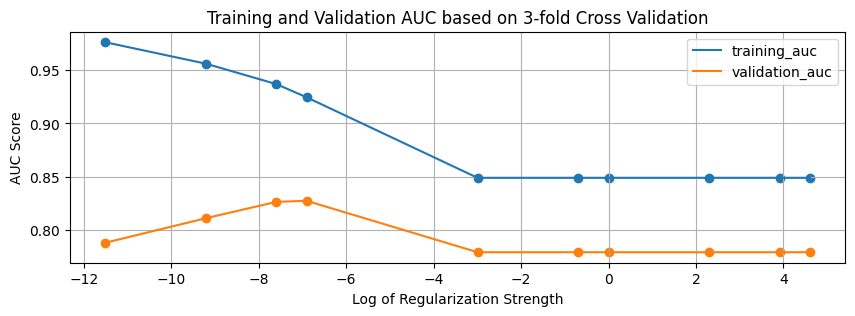

The best regularization strength parameter alpha on the random search over the given hyperparameter space for TFIDF Vectorizer using Linear SVM is :  {'alpha': 0.001}


In [50]:
SV = SGDClassifier(loss = 'hinge')

params = {'alpha': [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}

clf = RandomizedSearchCV(SV, param_distributions = params, scoring = 'roc_auc', cv=5, return_train_score = True, random_state = 42)
clf.fit(preprocessed_train_tfidf, Y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results.sort_values(by = "param_alpha", inplace=True)

train_auc = results["mean_train_score"]
train_std = results["std_train_score"]
cv_auc = results["mean_test_score"]
cv_std = results["std_test_score"]
hparam = pd.Series([np.log(x) for x in results.param_alpha.values])

plt.figure(figsize = (10,3))
plt.plot(hparam, train_auc, label = "training_auc")
plt.plot(hparam, cv_auc, label = "validation_auc")
plt.scatter(hparam, train_auc)
plt.scatter(hparam, cv_auc)
plt.xlabel("Log of Regularization Strength")
plt.ylabel("AUC Score")
plt.title("Training and Validation AUC based on 3-fold Cross Validation")
plt.legend()
plt.grid()
plt.show()

print("The best regularization strength parameter alpha on the random search " + 
      "over the given hyperparameter space for TFIDF Vectorizer using Linear SVM is : ", clf.best_params_)
clf_svm_tfidf_params = clf.best_params_

### Best Model Fitting

#### CountVectorizer/BOW(Bag of Words)

Params of a Best model - {'alpha': 0.001, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': 1000, 'n_iter_no_change': 5, 'n_jobs': None, 'penalty': 'l2', 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


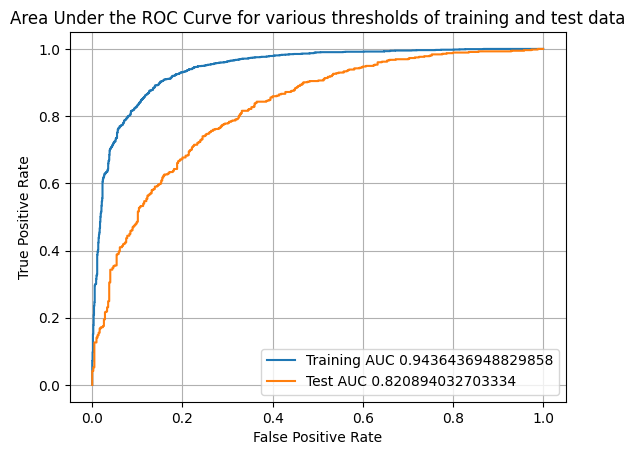

In [51]:
# Fitting the multinomial naive bayes algorithm
best_mod = SGDClassifier(loss = 'hinge')
best_mod.set_params(**clf_svm_cbow_params)
print("Params of a Best model - {}".format(best_mod.get_params()))
cal_clf = CalibratedClassifierCV(best_mod, method = "sigmoid", cv = 5)

cal_clf.fit(preprocessed_train_bow, Y_train)

y_train_pred = cal_clf.predict_proba(preprocessed_train_bow)[:,1]
y_test_pred = cal_clf.predict_proba(preprocessed_test_bow)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

#plt.figure(figsize = (10,5))
plt.plot(train_fpr, train_tpr, label = "Training AUC " + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "Test AUC " + str(auc(test_fpr, test_tpr)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area Under the ROC Curve for various thresholds of training and test data")
plt.legend()
plt.grid()
plt.show()

##### Overall - Test Data Prediction & Conf Matrix

the maximum value of tpr*(1-fpr) 0.7671957521909737 for threshold 0.5
Number of misclassified points  25.331971399387132


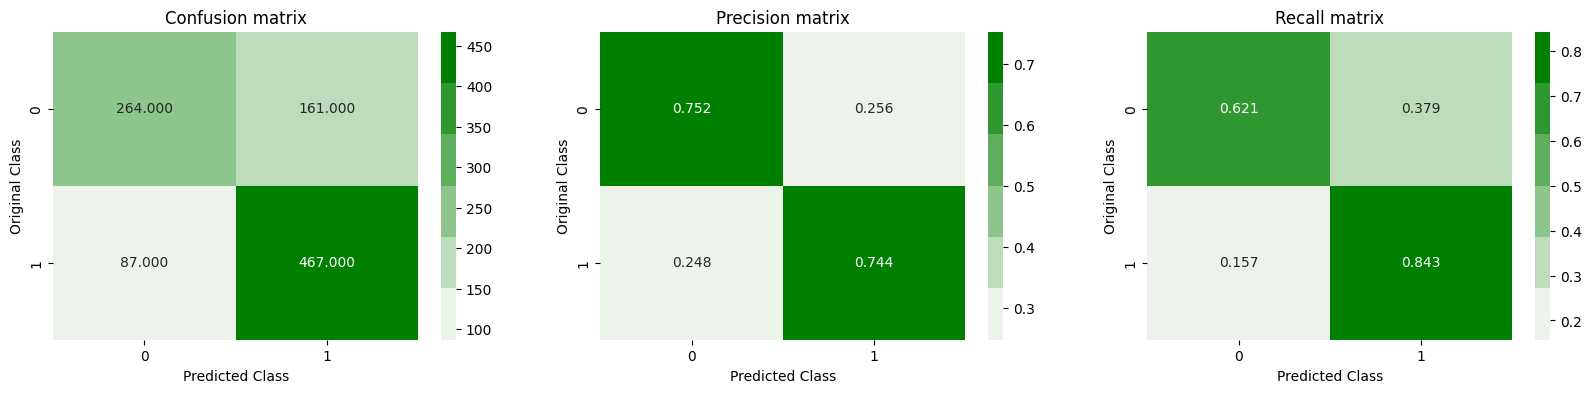

In [52]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
y_pred = predict_with_best_t(y_test_pred,best_t)
plot_confusion_matrix(Y_test, y_pred)

best_threshold_SVM_bow = best_t

In [53]:
accuracy_c1 = accuracy_score(Y_test, y_pred)
precision_c1 = precision_score(Y_test, y_pred)
recall_c1 = recall_score(Y_test, y_pred)
f1_c1 = f1_score(Y_test, y_pred)
print('Accuracy: %.3f' % accuracy_c1, 'Precision: %.3f' % precision_c1, 'Recall: %.3f' % recall_c1, 'F1: %.3f' % f1_c1)

Accuracy: 0.747 Precision: 0.744 Recall: 0.843 F1: 0.790


##### REDDIT - Test Data Prediction & Conf Matrix

the maximum value of tpr*(1-fpr) 0.7671957521909737 for threshold 0.5
Number of misclassified points  48.9051094890511


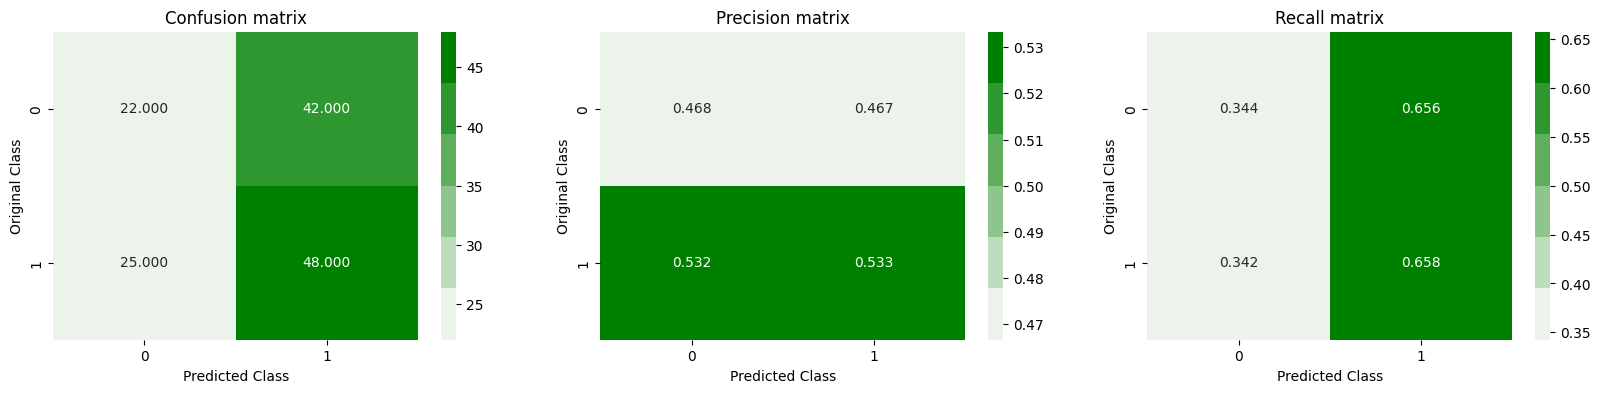

In [54]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
y_pred_reddit = predict_with_best_t(y_test_pred[Y_test_with_src[Y_test_with_src["source"].isin(["reddit"])].index], best_t)
Y_test_reddit = Y_test_with_src[Y_test_with_src["source"].isin(["reddit"])]["class"]
plot_confusion_matrix(Y_test_reddit, y_pred_reddit)

In [55]:
accuracy_reddit_c1 = accuracy_score(Y_test_reddit, y_pred_reddit)
precision_reddit_c1 = precision_score(Y_test_reddit, y_pred_reddit)
recall_reddit_c1 = recall_score(Y_test_reddit, y_pred_reddit)
f1_reddit_c1 = f1_score(Y_test_reddit, y_pred_reddit)
print('Accuracy: %.3f' % accuracy_reddit_c1, 'Precision: %.3f' % precision_reddit_c1, 'Recall: %.3f' % recall_reddit_c1, 'F1: %.3f' % f1_reddit_c1)

Accuracy: 0.511 Precision: 0.533 Recall: 0.658 F1: 0.589


#### TFIDF Vectorizer

Params of a Best model - {'alpha': 0.001, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': 1000, 'n_iter_no_change': 5, 'n_jobs': None, 'penalty': 'l2', 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


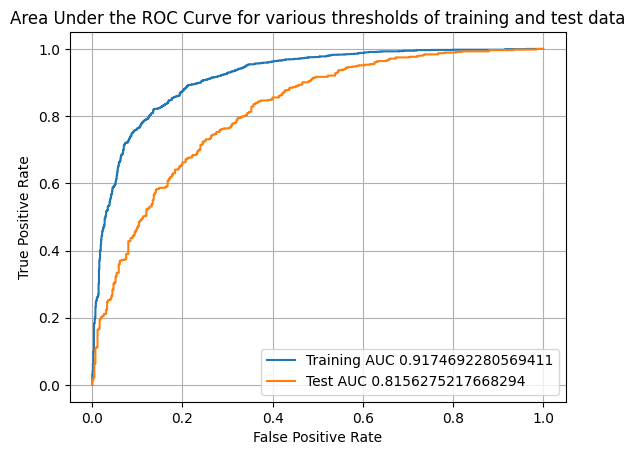

In [56]:
# Fitting the multinomial naive bayes algorithm
best_mod = SGDClassifier(loss = 'hinge')
best_mod.set_params(**clf_svm_tfidf_params)
print("Params of a Best model - {}".format(best_mod.get_params()))
cal_clf = CalibratedClassifierCV(best_mod, method = "sigmoid", cv = 5)

cal_clf.fit(preprocessed_train_tfidf, Y_train)

y_train_pred = cal_clf.predict_proba(preprocessed_train_tfidf)[:,1]
y_test_pred = cal_clf.predict_proba(preprocessed_test_tfidf)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

#plt.figure(figsize = (10,5))
plt.plot(train_fpr, train_tpr, label = "Training AUC " + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "Test AUC " + str(auc(test_fpr, test_tpr)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area Under the ROC Curve for various thresholds of training and test data")
plt.legend()
plt.grid()
plt.show()

##### OVERALL - Test Data Prediction & Conf Matrix

the maximum value of tpr*(1-fpr) 0.7090403010597781 for threshold 0.5
Number of misclassified points  25.025536261491315


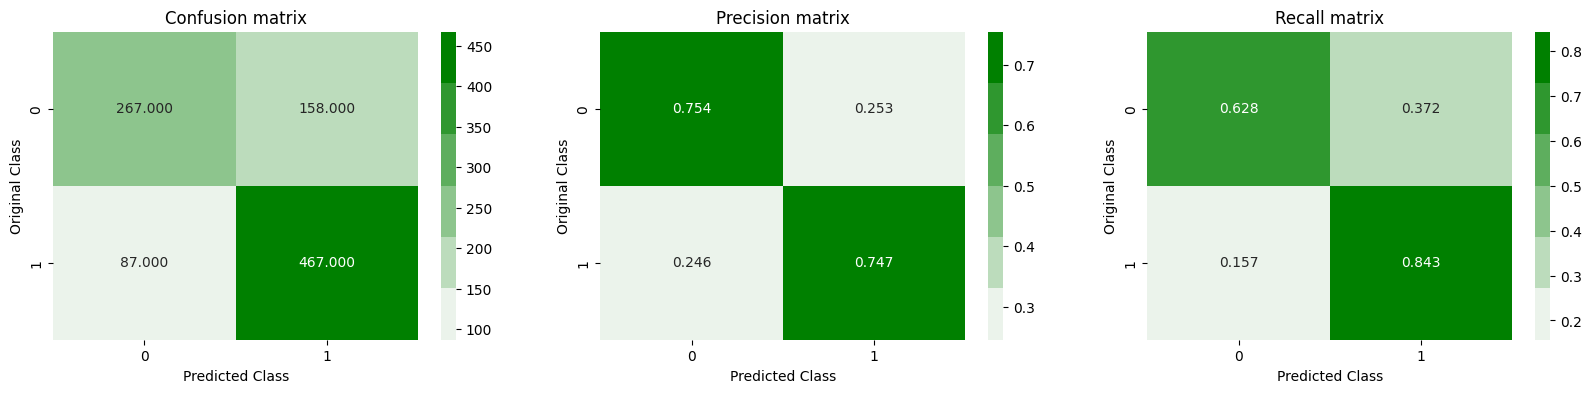

In [57]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
y_pred = predict_with_best_t(y_test_pred,best_t)
plot_confusion_matrix(Y_test, y_pred)

best_threshold_SVM_tfidf = best_t

In [58]:
accuracy_c2 = accuracy_score(Y_test, y_pred)
precision_c2 = precision_score(Y_test, y_pred)
recall_c2 = recall_score(Y_test, y_pred)
f1_c2 = f1_score(Y_test, y_pred)
print('Accuracy: %.3f' % accuracy_c2, 'Precision: %.3f' % precision_c2, 'Recall: %.3f' % recall_c2, 'F1: %.3f' % f1_c2)

Accuracy: 0.750 Precision: 0.747 Recall: 0.843 F1: 0.792


##### REDDIT - Test Data Prediction & Conf Matrix

the maximum value of tpr*(1-fpr) 0.7090403010597781 for threshold 0.5
Number of misclassified points  51.09489051094891


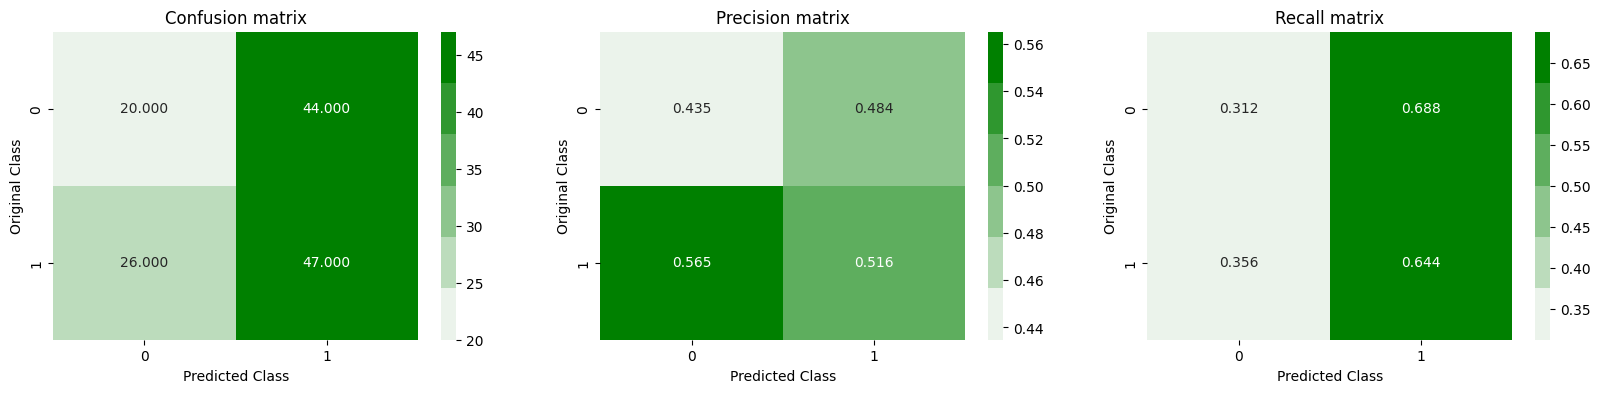

In [59]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
y_pred_reddit = predict_with_best_t(y_test_pred[Y_test_with_src[Y_test_with_src["source"].isin(["reddit"])].index], best_t)
Y_test_reddit = Y_test_with_src[Y_test_with_src["source"].isin(["reddit"])]["class"]
plot_confusion_matrix(Y_test_reddit, y_pred_reddit)

In [60]:
accuracy_reddit_c2 = accuracy_score(Y_test_reddit, y_pred_reddit)
precision_reddit_c2 = precision_score(Y_test_reddit, y_pred_reddit)
recall_reddit_c2 = recall_score(Y_test_reddit, y_pred_reddit)
f1_reddit_c2 = f1_score(Y_test_reddit, y_pred_reddit)
print('Accuracy: %.3f' % accuracy_reddit_c2, 'Precision: %.3f' % precision_reddit_c2, 'Recall: %.3f' % recall_reddit_c2, 'F1: %.3f' % f1_reddit_c2)

Accuracy: 0.489 Precision: 0.516 Recall: 0.644 F1: 0.573


## GRADIENT BOOSTED DECISION TREES
### Hyperparameter Tuning
    1. No. of Base Learners
    2. Learning Rate

### CountVectorizer/BOW(Bag of Words)

The best set of parameters for the GBDT Classifier on the BOW featurized data are : {'n_estimators': 50, 'learning_rate': 0.2}


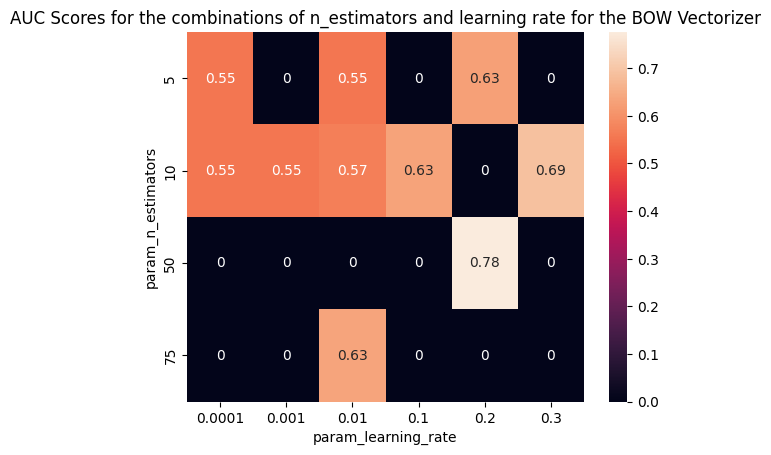

In [61]:
gbdt_clf = gbc()

params = {'n_estimators':[5,10,50,75], 'learning_rate':[0.0001,0.001,0.01,0.1,0.2,0.3]}

clf = RandomizedSearchCV(gbdt_clf, param_distributions = params, scoring = 'roc_auc', cv=5, return_train_score = True, random_state = 42)
clf.fit(preprocessed_train_bow, Y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results.sort_values(by = ["param_n_estimators","param_learning_rate"], inplace=True)


train_auc = results["mean_train_score"]
train_std = results["std_train_score"]
cv_auc = results["mean_test_score"]
cv_std = results["std_test_score"]

score_df = pd.pivot_table(data = results, index = "param_n_estimators", columns = "param_learning_rate", values = "mean_test_score")

# Removing the nan values from the dataset to avoid any errors during plotting of the auc scores for various combinations
score_df.fillna(0, inplace=True)

sns.heatmap(score_df, annot = True)
plt.title("AUC Scores for the combinations of n_estimators and learning rate for the BOW Vectorizer")

print("The best set of parameters for the GBDT Classifier on the BOW featurized data are : {}".format(clf.best_params_))
clf_gbdt_cbow_params = clf.best_params_

### TFIDF Vectorizer

The best set of parameters for the GBDT Classifier on the TFIDF featurized data are : {'n_estimators': 50, 'learning_rate': 0.2}


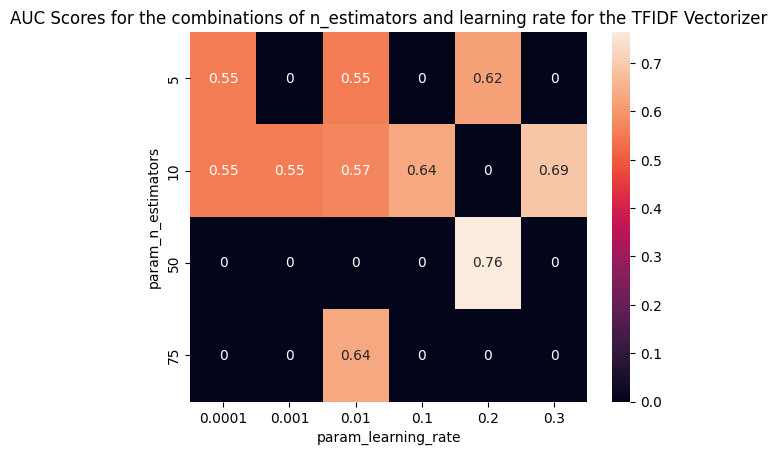

In [62]:
gbdt_clf = gbc()

params = {'n_estimators':[5,10,50,75], 'learning_rate':[0.0001,0.001,0.01,0.1,0.2,0.3]}

clf = RandomizedSearchCV(gbdt_clf, param_distributions = params, scoring = 'roc_auc', cv=5, return_train_score = True, random_state = 42)
clf.fit(preprocessed_train_tfidf, Y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results.sort_values(by = ["param_n_estimators","param_learning_rate"], inplace=True)


train_auc = results["mean_train_score"]
train_std = results["std_train_score"]
cv_auc = results["mean_test_score"]
cv_std = results["std_test_score"]

score_df = pd.pivot_table(data = results, index = "param_n_estimators", columns = "param_learning_rate", values = "mean_test_score")

# Removing the nan values from the dataset to avoid any errors during plotting of the auc scores for various combinations
score_df.fillna(0, inplace=True)

sns.heatmap(score_df, annot = True)
plt.title("AUC Scores for the combinations of n_estimators and learning rate for the TFIDF Vectorizer")

print("The best set of parameters for the GBDT Classifier on the TFIDF featurized data are : {}".format(clf.best_params_))
clf_gbdt_tfidf_params = clf.best_params_

### Best Model Fitting

#### CountVectorizer/BOW(Bag of Words)

Params of a Best model - {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.2, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


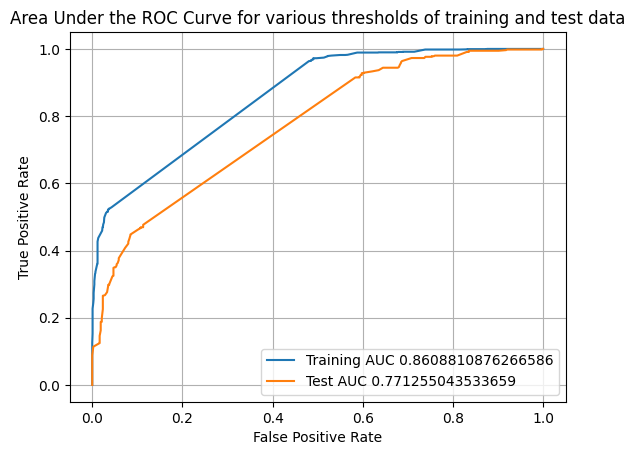

In [63]:
# Fitting the multinomial naive bayes algorithm
best_mod = gbc()
best_mod.set_params(**clf_gbdt_cbow_params)
print("Params of a Best model - {}".format(best_mod.get_params()))

best_mod.fit(preprocessed_train_bow, Y_train)

y_train_pred = best_mod.predict_proba(preprocessed_train_bow)[:,1]
y_test_pred = best_mod.predict_proba(preprocessed_test_bow)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

#plt.figure(figsize = (10,5))
plt.plot(train_fpr, train_tpr, label = "Training AUC " + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "Test AUC " + str(auc(test_fpr, test_tpr)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area Under the ROC Curve for various thresholds of training and test data")
plt.legend()
plt.grid()
plt.show()

##### OVERALL - Test Data Prediction & Conf Matrix

the maximum value of tpr*(1-fpr) 0.5058698527124968 for threshold 0.5
Number of misclassified points  30.234933605720123


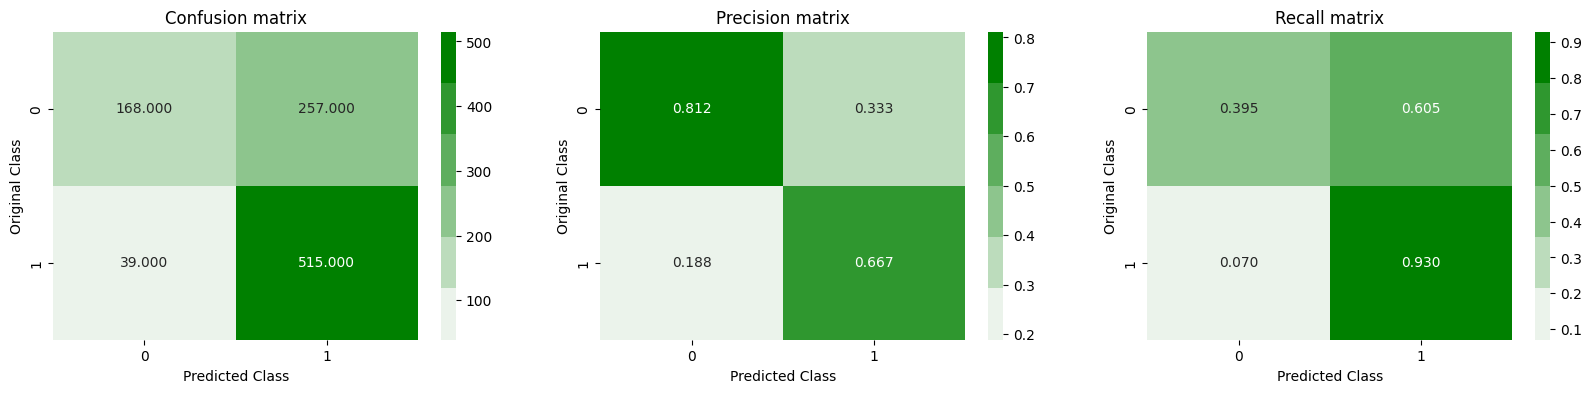

In [64]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
y_pred = predict_with_best_t(y_test_pred,best_t)
plot_confusion_matrix(Y_test, y_pred)

best_threshold_gbdt_bow = best_t

In [65]:
accuracy_d1 = accuracy_score(Y_test, y_pred)
precision_d1 = precision_score(Y_test, y_pred)
recall_d1 = recall_score(Y_test, y_pred)
f1_d1 = f1_score(Y_test, y_pred)
print('Accuracy: %.3f' % accuracy_d1, 'Precision: %.3f' % precision_d1, 'Recall: %.3f' % recall_d1, 'F1: %.3f' % f1_d1)

Accuracy: 0.698 Precision: 0.667 Recall: 0.930 F1: 0.777


##### REDDIT - Test Data Prediction & Conf Matrix

the maximum value of tpr*(1-fpr) 0.5058698527124968 for threshold 0.5
Number of misclassified points  48.9051094890511


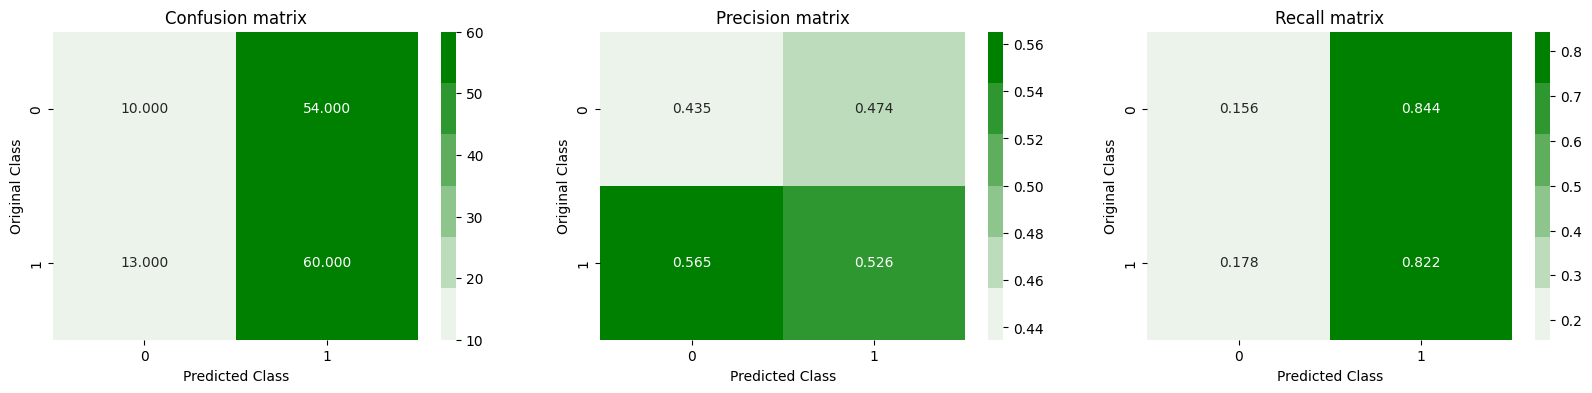

In [66]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
y_pred_reddit = predict_with_best_t(y_test_pred[Y_test_with_src[Y_test_with_src["source"].isin(["reddit"])].index], best_t)
Y_test_reddit = Y_test_with_src[Y_test_with_src["source"].isin(["reddit"])]["class"]
plot_confusion_matrix(Y_test_reddit, y_pred_reddit)

In [67]:
accuracy_reddit_d1 = accuracy_score(Y_test_reddit, y_pred_reddit)
precision_reddit_d1 = precision_score(Y_test_reddit, y_pred_reddit)
recall_reddit_d1 = recall_score(Y_test_reddit, y_pred_reddit)
f1_reddit_d1 = f1_score(Y_test_reddit, y_pred_reddit)
print('Accuracy: %.3f' % accuracy_reddit_d1, 'Precision: %.3f' % precision_reddit_d1, 'Recall: %.3f' % recall_reddit_d1, 'F1: %.3f' % f1_reddit_d1)

Accuracy: 0.511 Precision: 0.526 Recall: 0.822 F1: 0.642


#### TFIDF Vectorizer

Params of a Best model - {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.2, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


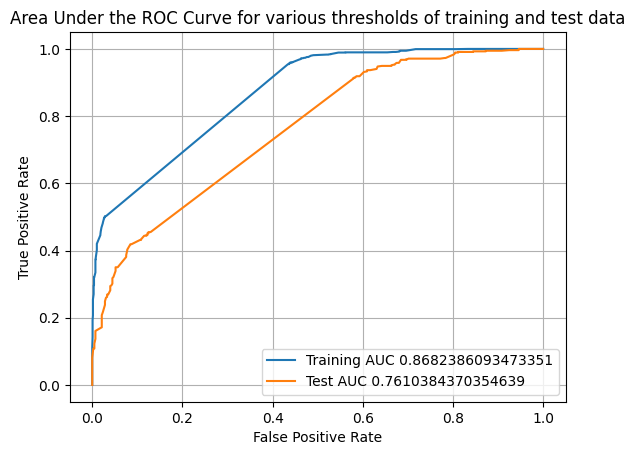

In [68]:
# Fitting the multinomial naive bayes algorithm
best_mod = gbc()
best_mod.set_params(**clf_gbdt_tfidf_params)
print("Params of a Best model - {}".format(best_mod.get_params()))

best_mod.fit(preprocessed_train_tfidf, Y_train)

y_train_pred = best_mod.predict_proba(preprocessed_train_tfidf)[:,1]
y_test_pred = best_mod.predict_proba(preprocessed_test_tfidf)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

#plt.figure(figsize = (10,5))
plt.plot(train_fpr, train_tpr, label = "Training AUC " + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "Test AUC " + str(auc(test_fpr, test_tpr)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area Under the ROC Curve for various thresholds of training and test data")
plt.legend()
plt.grid()
plt.show()

##### OVERALL - Test Data Prediction & Conf Matrix

the maximum value of tpr*(1-fpr) 0.5400699334412868 for threshold 0.5
Number of misclassified points  30.745658835546475


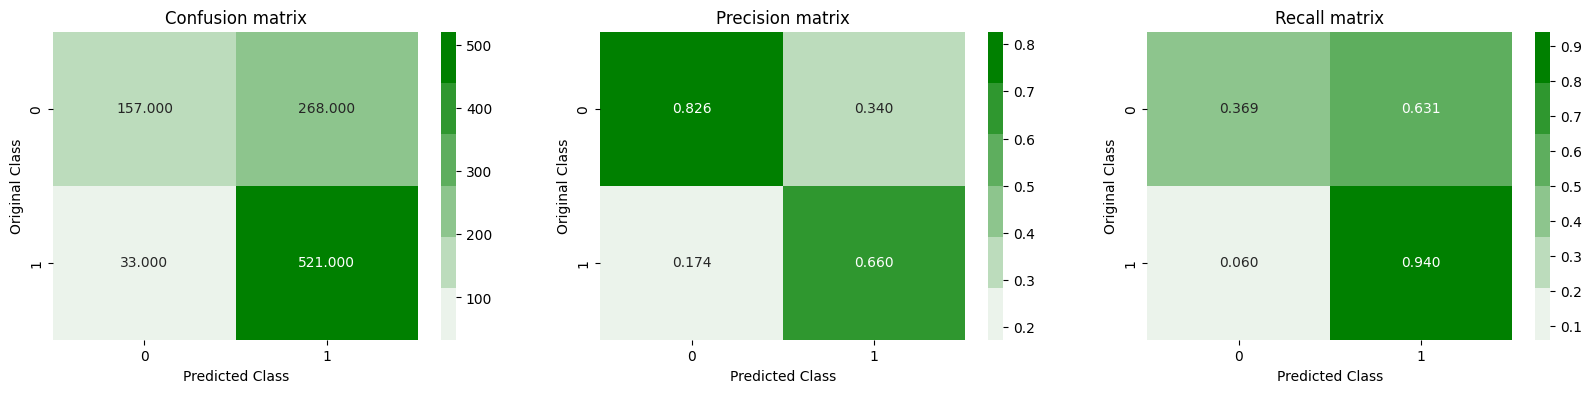

In [69]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
y_pred = predict_with_best_t(y_test_pred,best_t)
plot_confusion_matrix(Y_test, y_pred)

best_threshold_gbdt_tfidf = best_t

In [70]:
accuracy_d2 = accuracy_score(Y_test, y_pred)
precision_d2 = precision_score(Y_test, y_pred)
recall_d2 = recall_score(Y_test, y_pred)
f1_d2 = f1_score(Y_test, y_pred)
print('Accuracy: %.3f' % accuracy_d2, 'Precision: %.3f' % precision_d2, 'Recall: %.3f' % recall_d2, 'F1: %.3f' % f1_d2)

Accuracy: 0.693 Precision: 0.660 Recall: 0.940 F1: 0.776


##### REDDIT - Test Data Prediction & Conf Matrix

the maximum value of tpr*(1-fpr) 0.5400699334412868 for threshold 0.5
Number of misclassified points  48.175182481751825


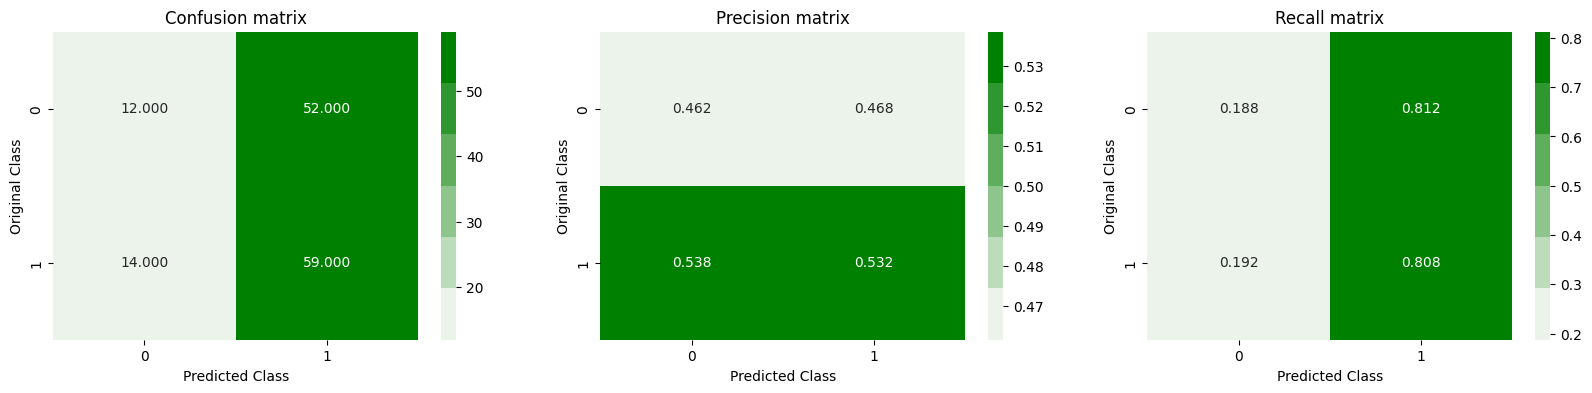

In [71]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
y_pred_reddit = predict_with_best_t(y_test_pred[Y_test_with_src[Y_test_with_src["source"].isin(["reddit"])].index], best_t)
Y_test_reddit = Y_test_with_src[Y_test_with_src["source"].isin(["reddit"])]["class"]
plot_confusion_matrix(Y_test_reddit, y_pred_reddit)

In [72]:
accuracy_reddit_d2 = accuracy_score(Y_test_reddit, y_pred_reddit)
precision_reddit_d2 = precision_score(Y_test_reddit, y_pred_reddit)
recall_reddit_d2 = recall_score(Y_test_reddit, y_pred_reddit)
f1_reddit_d2 = f1_score(Y_test_reddit, y_pred_reddit)
print('Accuracy: %.3f' % accuracy_reddit_d2, 'Precision: %.3f' % precision_reddit_d2, 'Recall: %.3f' % recall_reddit_d2, 'F1: %.3f' % f1_reddit_d2)

Accuracy: 0.518 Precision: 0.532 Recall: 0.808 F1: 0.641


## RANDOM FORESTS
### Hyperparameter Tuning
    1. n_estimators which is the number of base learners or the individual decision trees.
    2. max_depth which is the maximum depth to which the decision trees should grow.

### CountVectorizer/BOW(Bag of Words)

The best set of parameters for the Random Forest Classifier on the BOW featurized data are : {'n_estimators': 100, 'max_depth': 75}


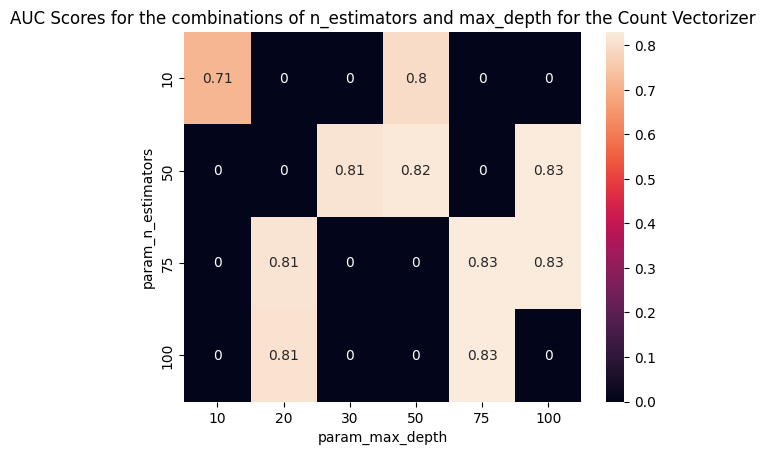

In [73]:
rf_clf = RandomForestClassifier()

params = {'n_estimators':[10,25,50,75,100], 'max_depth':[10,20,30,50,75,100]}

clf = RandomizedSearchCV(rf_clf, param_distributions = params, scoring = 'roc_auc', cv=5, return_train_score = True, random_state = 42)
clf.fit(preprocessed_train_bow, Y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results.sort_values(by = ["param_n_estimators","param_max_depth"], inplace=True)


train_auc = results["mean_train_score"]
train_std = results["std_train_score"]
cv_auc = results["mean_test_score"]
cv_std = results["std_test_score"]

score_df = pd.pivot_table(data = results, index = "param_n_estimators", columns = "param_max_depth", values = "mean_test_score")

# Removing the nan values from the dataset to avoid any errors during plotting of the auc scores for various combinations
score_df.fillna(0, inplace=True)

sns.heatmap(score_df, annot = True)
plt.title("AUC Scores for the combinations of n_estimators and max_depth for the Count Vectorizer")

print("The best set of parameters for the Random Forest Classifier on the BOW featurized data are : {}".format(clf.best_params_))
clf_rf_cbow_params = clf.best_params_

### TFIDF Vectorizer

The best set of parameters for the Random Forest Classifier on the TFIDF featurized data are : {'n_estimators': 75, 'max_depth': 100}


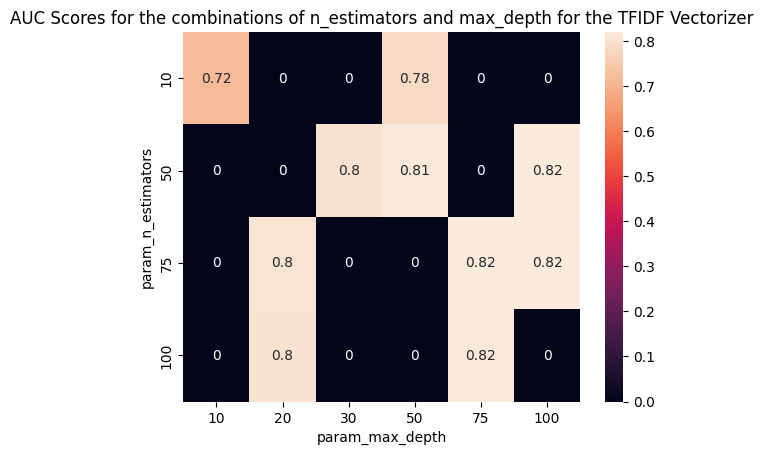

In [74]:
rf_clf = RandomForestClassifier()

params = {'n_estimators':[10,25,50,75,100], 'max_depth':[10,20,30,50,75,100]}

clf = RandomizedSearchCV(rf_clf, param_distributions = params, scoring = 'roc_auc', cv=5, return_train_score = True, random_state = 42)
clf.fit(preprocessed_train_tfidf, Y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results.sort_values(by = ["param_n_estimators","param_max_depth"], inplace=True)


train_auc = results["mean_train_score"]
train_std = results["std_train_score"]
cv_auc = results["mean_test_score"]
cv_std = results["std_test_score"]

score_df = pd.pivot_table(data = results, index = "param_n_estimators", columns = "param_max_depth", values = "mean_test_score")

# Removing the nan values from the dataset to avoid any errors during plotting of the auc scores for various combinations
score_df.fillna(0, inplace=True)

sns.heatmap(score_df, annot = True)
plt.title("AUC Scores for the combinations of n_estimators and max_depth for the TFIDF Vectorizer")

print("The best set of parameters for the Random Forest Classifier on the TFIDF featurized data are : {}".format(clf.best_params_))
clf_rf_tfidf_params = clf.best_params_

### Best Model Fitting

#### CountVectorizer/BOW(Bag of Words)

Params of a Best model - {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.2, 'loss': 'log_loss', 'max_depth': 75, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


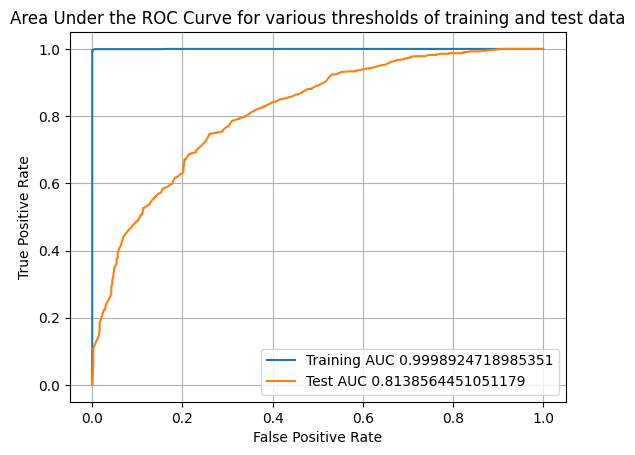

In [75]:
# Fitting the multinomial naive bayes algorithm
best_mod_rf_bow = RandomForestClassifier(oob_score = True, random_state = 42)
best_mod.set_params(**clf_rf_cbow_params)
print("Params of a Best model - {}".format(best_mod.get_params()))

best_mod_rf_bow.fit(preprocessed_train_bow, Y_train)

y_train_pred = best_mod_rf_bow.predict_proba(preprocessed_train_bow)[:,1]
y_test_pred = best_mod_rf_bow.predict_proba(preprocessed_test_bow)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

#plt.figure(figsize = (10,5))
plt.plot(train_fpr, train_tpr, label = "Training AUC " + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "Test AUC " + str(auc(test_fpr, test_tpr)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area Under the ROC Curve for various thresholds of training and test data")
plt.legend()
plt.grid()
plt.show()

##### Overall - Test Data Prediction & Conf Matrix

the maximum value of tpr*(1-fpr) 0.9954252110150369 for threshold 0.5
Number of misclassified points  25.944841675178754


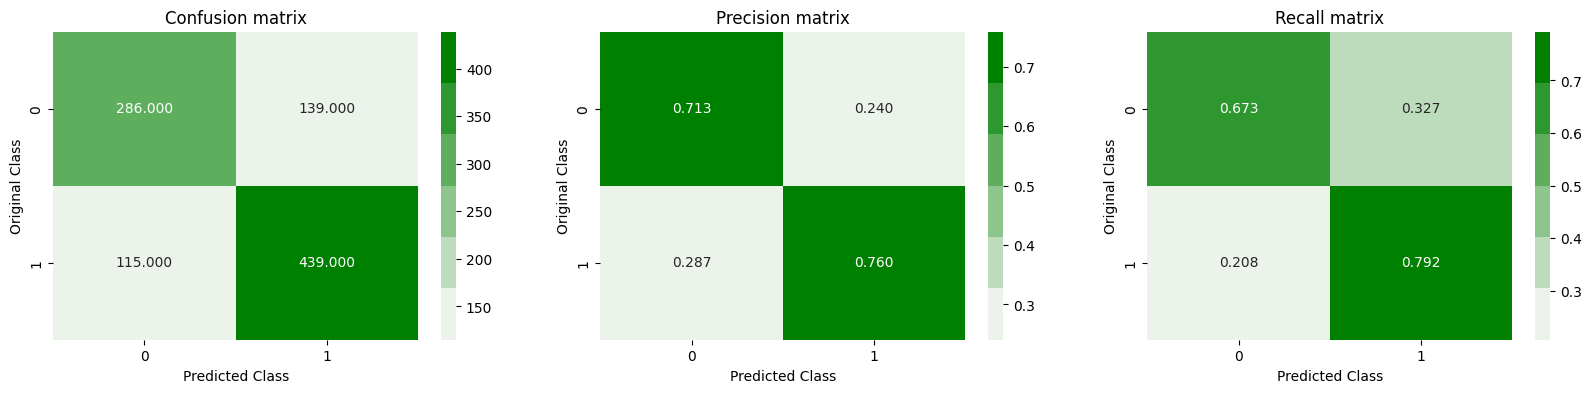

In [76]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
y_pred = predict_with_best_t(y_test_pred,best_t)
plot_confusion_matrix(Y_test, y_pred)

best_threshold_rfclf_bow = best_t

In [77]:
accuracy_e1 = accuracy_score(Y_test, y_pred)
precision_e1 = precision_score(Y_test, y_pred)
recall_e1 = recall_score(Y_test, y_pred)
f1_e1 = f1_score(Y_test, y_pred)
print('Accuracy: %.3f' % accuracy_e1, 'Precision: %.3f' % precision_e1, 'Recall: %.3f' % recall_e1, 'F1: %.3f' % f1_e1)

Accuracy: 0.741 Precision: 0.760 Recall: 0.792 F1: 0.776


##### REDDIT - Test Data Prediction & Conf Matrix

the maximum value of tpr*(1-fpr) 0.9954252110150369 for threshold 0.5
Number of misclassified points  46.715328467153284


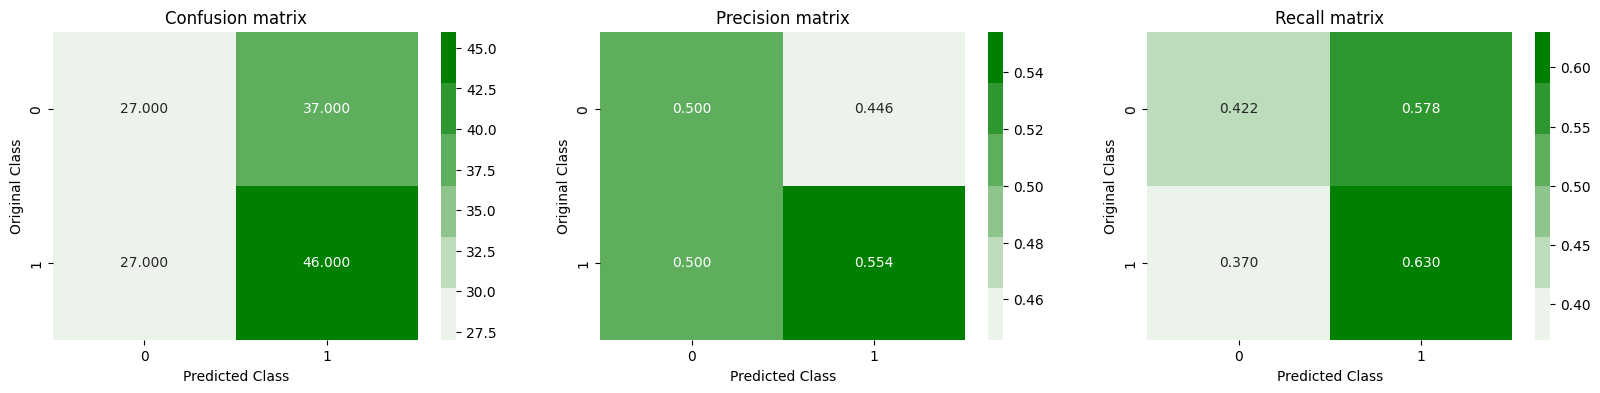

In [78]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
y_pred_reddit = predict_with_best_t(y_test_pred[Y_test_with_src[Y_test_with_src["source"].isin(["reddit"])].index], best_t)
Y_test_reddit = Y_test_with_src[Y_test_with_src["source"].isin(["reddit"])]["class"]
plot_confusion_matrix(Y_test_reddit, y_pred_reddit)

In [79]:
accuracy_reddit_e1 = accuracy_score(Y_test_reddit, y_pred_reddit)
precision_reddit_e1 = precision_score(Y_test_reddit, y_pred_reddit)
recall_reddit_e1 = recall_score(Y_test_reddit, y_pred_reddit)
f1_reddit_e1 = f1_score(Y_test_reddit, y_pred_reddit)
print('Accuracy: %.3f' % accuracy_reddit_e1, 'Precision: %.3f' % precision_reddit_e1, 'Recall: %.3f' % recall_reddit_e1, 'F1: %.3f' % f1_reddit_e1)

Accuracy: 0.533 Precision: 0.554 Recall: 0.630 F1: 0.590


#### TFIDF Vectorizer

Params of a Best model - {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.2, 'loss': 'log_loss', 'max_depth': 100, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 75, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


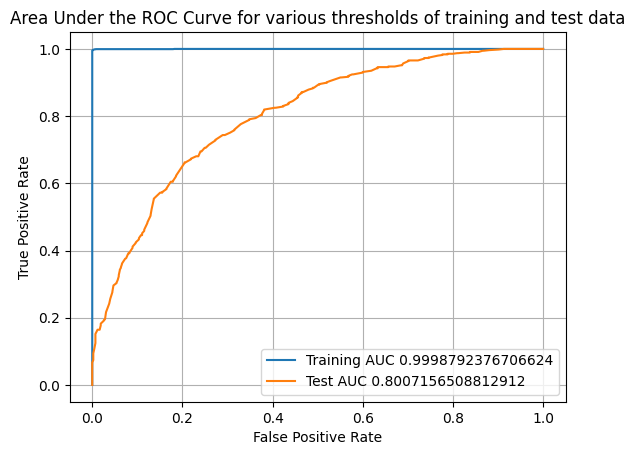

In [80]:
# Fitting the multinomial naive bayes algorithm
best_mod_rf_tfidf = RandomForestClassifier(oob_score = True, random_state = 42)
best_mod.set_params(**clf_rf_tfidf_params)
print("Params of a Best model - {}".format(best_mod.get_params()))

best_mod_rf_tfidf.fit(preprocessed_train_tfidf, Y_train)

y_train_pred = best_mod_rf_tfidf.predict_proba(preprocessed_train_tfidf)[:,1]
y_test_pred = best_mod_rf_tfidf.predict_proba(preprocessed_test_tfidf)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

#plt.figure(figsize = (10,5))
plt.plot(train_fpr, train_tpr, label = "Training AUC " + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "Test AUC " + str(auc(test_fpr, test_tpr)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area Under the ROC Curve for various thresholds of training and test data")
plt.legend()
plt.grid()
plt.show()

##### OVERALL - Test Data Prediction & Conf Matrix

the maximum value of tpr*(1-fpr) 0.9954252110150369 for threshold 0.5
Number of misclassified points  27.374872318692546


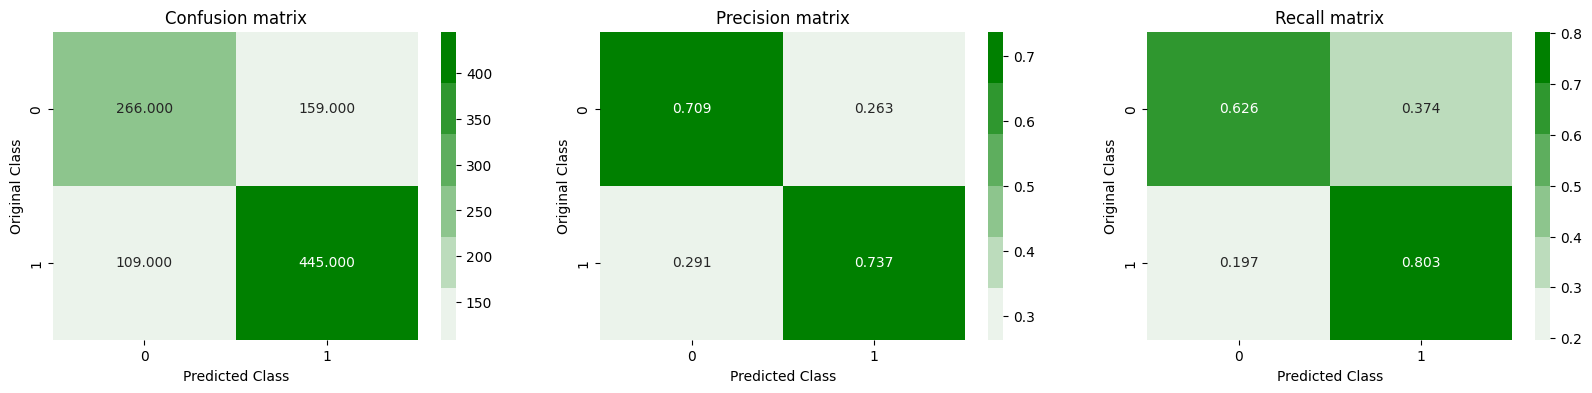

In [81]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
y_pred = predict_with_best_t(y_test_pred,best_t)
plot_confusion_matrix(Y_test, y_pred)

best_threshold_rfclf_tfidf = best_t

In [82]:
accuracy_e2 = accuracy_score(Y_test, y_pred)
precision_e2 = precision_score(Y_test, y_pred)
recall_e2 = recall_score(Y_test, y_pred)
f1_e2 = f1_score(Y_test, y_pred)
print('Accuracy: %.3f' % accuracy_e2, 'Precision: %.3f' % precision_e2, 'Recall: %.3f' % recall_e2, 'F1: %.3f' % f1_e2)

Accuracy: 0.726 Precision: 0.737 Recall: 0.803 F1: 0.769


##### REDDIT - Test Data Prediction & Conf Matrix

the maximum value of tpr*(1-fpr) 0.9954252110150369 for threshold 0.5
Number of misclassified points  47.44525547445255


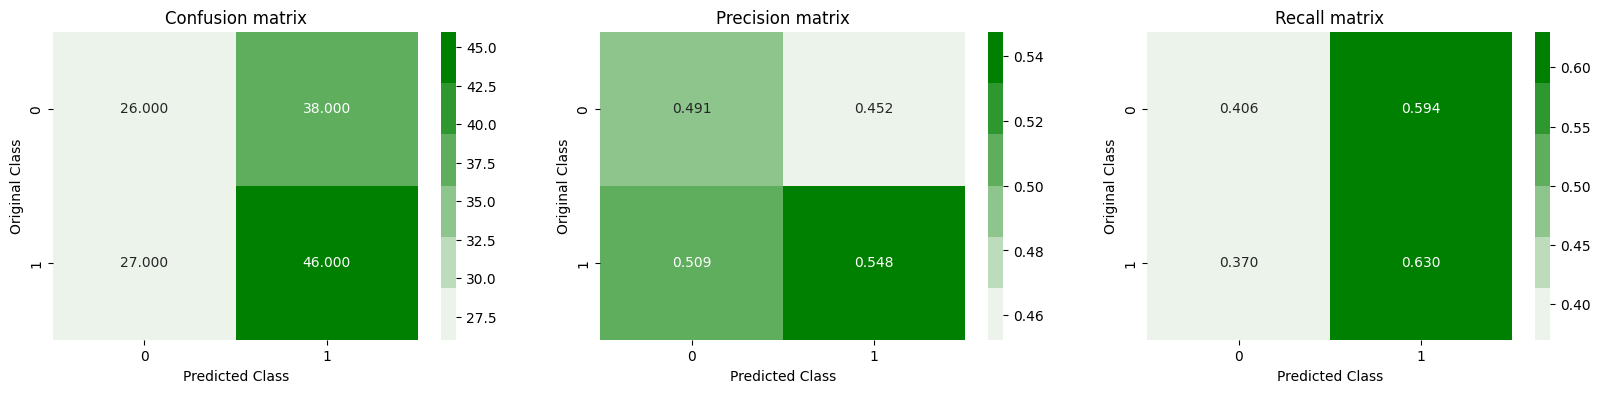

In [83]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
y_pred_reddit = predict_with_best_t(y_test_pred[Y_test_with_src[Y_test_with_src["source"].isin(["reddit"])].index], best_t)
Y_test_reddit = Y_test_with_src[Y_test_with_src["source"].isin(["reddit"])]["class"]
plot_confusion_matrix(Y_test_reddit, y_pred_reddit)

In [84]:
accuracy_reddit_e2 = accuracy_score(Y_test_reddit, y_pred_reddit)
precision_reddit_e2 = precision_score(Y_test_reddit, y_pred_reddit)
recall_reddit_e2 = recall_score(Y_test_reddit, y_pred_reddit)
f1_reddit_e2 = f1_score(Y_test_reddit, y_pred_reddit)
print('Accuracy: %.3f' % accuracy_reddit_e2, 'Precision: %.3f' % precision_reddit_e2, 'Recall: %.3f' % recall_reddit_e2, 'F1: %.3f' % f1_reddit_e2)

Accuracy: 0.526 Precision: 0.548 Recall: 0.630 F1: 0.586


# Model Summary

I have used five models to fit on the trigram BOW and tfidf vectorized data and here are the results summarized in one table as under:-

In [86]:
summary = {
    'Model': ['Naive Bayes','Logistic Regression','Linear SVM','GBDT','Random Forest']*2,
    'Vectorizer': ['BOW_Trigrams']*5+['TFIDF_Trigrams']*5, 
    # 'Accuracy': [accuracy_a1, accuracy_b1, accuracy_c1, accuracy_d1, accuracy_e1, 
    #              accuracy_a2, accuracy_b2, accuracy_c2, accuracy_d2, accuracy_e2],
    # 'Precision': [precision_a1, precision_b1, precision_c1, precision_d1, precision_e1, 
    #               precision_a2, precision_b2, precision_c2, precision_d2, precision_e2],
    # 'Recall': [recall_a1, recall_b1, recall_c1, recall_d1, recall_e1,
    #            recall_a2, recall_b2, recall_c2, recall_d2, recall_e2],
    'REDDIT_F1': [f1_reddit_a1, f1_reddit_b1, f1_reddit_c1, f1_reddit_d1, f1_reddit_e1,
                  f1_reddit_a2, f1_reddit_b2, f1_reddit_c2, f1_reddit_d2, f1_reddit_e2],
    'F1': [f1_a1, f1_b1, f1_c1, f1_d1, f1_e1, 
           f1_a2, f1_b2, f1_c2, f1_d2, f1_e2]
    
}

fin_summary = pd.DataFrame(summary)

fin_summary.round(3)

,Model,Vectorizer,REDDIT_F1,F1
0,Naive Bayes,BOW_Trigrams,0.579,0.772
1,Logistic Regression,BOW_Trigrams,0.571,0.798
2,Linear SVM,BOW_Trigrams,0.589,0.790
3,GBDT,BOW_Trigrams,0.642,0.777
4,Random Forest,BOW_Trigrams,0.590,0.776
5,Naive Bayes,TFIDF_Trigrams,0.553,0.784
6,Logistic Regression,TFIDF_Trigrams,0.578,0.792
7,Linear SVM,TFIDF_Trigrams,0.573,0.792
8,GBDT,TFIDF_Trigrams,0.641,0.776
9,Random Forest,TFIDF_Trigrams,0.586,0.769
